In [1]:
import numpy as np
import matplotlib.pyplot as plt




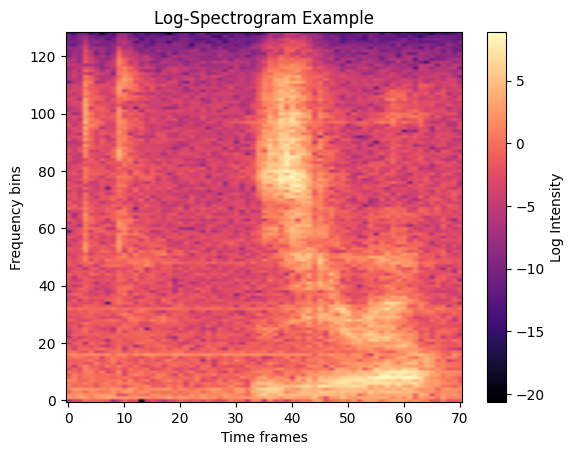

In [2]:
y = np.load('y_digits.npy')
x = np.load('X_digits.npy')

plt.imshow(x[2], aspect='auto', origin='lower', cmap='magma')
plt.colorbar(label="Log Intensity")
plt.xlabel("Time frames")
plt.ylabel("Frequency bins")
plt.title("Log-Spectrogram Example")
plt.show()

In [3]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np


X_tensor = np.expand_dims(x, axis=-1).astype(np.float32)
Y_tensor = y.astype(np.float32)

X_train, X_temp, y_train, y_temp = train_test_split(
    X_tensor, Y_tensor, test_size=0.3, stratify=Y_tensor
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp
)

print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

batch_size = 64

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=len(X_train)).batch(batch_size)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(batch_size)

2025-09-28 15:19:39.057672: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


(24941, 129, 71, 1) (5345, 129, 71, 1) (5345, 129, 71, 1) (24941,) (5345,) (5345,)


I0000 00:00:1759065583.906014  249781 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 12328 MB memory:  -> device: 0, name: AMD Radeon RX 9070 XT, pci bus id: 0000:03:00.0
2025-09-28 15:19:43.944700: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 913738476 exceeds 10% of free system memory.
2025-09-28 15:19:45.373755: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 913738476 exceeds 10% of free system memory.


In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models

def vgg_block(num_convs, out_channels):
    block = tf.keras.Sequential()
    for _ in range(num_convs):
        block.add(layers.Conv2D(out_channels, kernel_size=3, padding="same", activation="relu"))
    block.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2))
    return block

class Net(tf.keras.Model):
    def __init__(self, num_classes=10):
        super(Net, self).__init__()
        self.classes = num_classes

        self.conv_blks = models.Sequential([
            vgg_block(3, 256),
            vgg_block(3, 256),
            vgg_block(3, 256),
        ])

        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(4096, activation="relu")
        self.dense2 = layers.Dense(4096, activation="relu")
        self.dropout = layers.Dropout(0.5)
        self.out_layer = layers.Dense(num_classes)

    def call(self, x, training=False):
        x = self.conv_blks(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        if training:
            x = self.dropout(x, training=training)
        logits = self.out_layer(x)
        pred_digits = tf.argmax(logits, axis=1)
        return logits, pred_digits


In [5]:
import tensorflow as tf
import numpy as np
from tqdm import tqdm

model = Net()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

num_epochs = 10
fraction = 0.3
patience = 3
threshold = 0.01
best_val_loss = 999999
counter = 0
discardLimit = (1 - fraction) * len(train_dataset)

train_losses = []
val_losses = []

class ManualReduceLROnPlateau:
    def __init__(self, optimizer, factor=0.5, patience=1, min_delta=0.01, min_lr=1e-7, verbose=1):
        self.optimizer = optimizer
        self.factor = factor
        self.patience = patience
        self.min_delta = min_delta
        self.min_lr = min_lr
        self.verbose = verbose
        self.wait = 0
        self.best = float("inf")

    def step(self, current):
        if self.best - current > self.min_delta:
            self.best = current
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                old_lr = float(self.optimizer.learning_rate.numpy())
                new_lr = max(old_lr * self.factor, self.min_lr)
                self.optimizer.learning_rate.assign(new_lr)
                if self.verbose:
                    print(f"ReduceLROnPlateau reducing learning rate to {new_lr:.6f}")
                self.wait = 0

reduce_lr = ManualReduceLROnPlateau(
    optimizer,
    factor=0.5,
    patience=1,
    verbose=1,
    min_delta=0.01
)

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    total_loss = 0.0
    actual_batches = 0
    discarded_batches = 0

    for images, targets in tqdm(train_dataset):
        random_number = np.random.rand()
        if random_number > fraction and discarded_batches < discardLimit:
            discarded_batches += 1
            continue

        actual_batches += 1
        with tf.GradientTape() as tape:
            logits, _ = model(images, training=True)
            loss = loss_fn(targets, logits)

        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        total_loss += loss.numpy()
        print(f"Loss = {loss.numpy():.4f}, actual_batches = {actual_batches}, discarded_batches = {discarded_batches}")

    avg_loss = total_loss / max(actual_batches, 1)
    print("Epoch finished, looking at validation set...")

    val_loss = 0.0
    val_batches = 0
    for images, targets in val_dataset:
        logits, _ = model(images, training=False)
        loss = loss_fn(targets, logits)
        val_loss += loss.numpy()
        val_batches += 1

    avg_val_loss = val_loss / max(val_batches, 1)

    reduce_lr.step(avg_val_loss)

    print(f"Epoch {epoch+1}: Train Loss = {avg_loss:.4f}, Val Loss = {avg_val_loss:.4f}, lr = {optimizer.learning_rate}")
    train_losses.append(avg_loss)
    val_losses.append(avg_val_loss)

    if best_val_loss - avg_val_loss > threshold:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model.")
        best_val_loss = avg_val_loss
        counter = 0
        model.save_weights("Net_best.weights.h5")
    else:
        print(f"No significant improvement in validation loss. Best: {best_val_loss:.4f}, Current: {avg_val_loss:.4f} for {counter+1} epochs.")
        counter += 1

    if counter >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break


Epoch 1/10


  1%|          | 2/390 [00:04<14:50,  2.29s/it]

Loss = 2.3075, actual_batches = 1, discarded_batches = 1


  1%|▏         | 5/390 [00:05<06:51,  1.07s/it]

Loss = 2.3825, actual_batches = 2, discarded_batches = 3


  3%|▎         | 11/390 [00:07<03:17,  1.92it/s]

Loss = 2.2828, actual_batches = 3, discarded_batches = 8


  3%|▎         | 12/390 [00:08<04:08,  1.52it/s]

Loss = 2.3256, actual_batches = 4, discarded_batches = 8


  3%|▎         | 13/390 [00:10<04:59,  1.26it/s]

Loss = 2.2686, actual_batches = 5, discarded_batches = 8


  4%|▍         | 16/390 [00:11<04:11,  1.49it/s]

Loss = 2.3303, actual_batches = 6, discarded_batches = 10


  5%|▌         | 21/390 [00:13<03:00,  2.05it/s]

Loss = 2.3223, actual_batches = 7, discarded_batches = 14


  6%|▌         | 22/390 [00:14<03:45,  1.63it/s]

Loss = 2.3273, actual_batches = 8, discarded_batches = 14


  6%|▌         | 24/390 [00:16<03:58,  1.54it/s]

Loss = 2.2883, actual_batches = 9, discarded_batches = 15


  6%|▋         | 25/390 [00:17<04:48,  1.26it/s]

Loss = 2.2938, actual_batches = 10, discarded_batches = 15


  7%|▋         | 28/390 [00:19<04:06,  1.47it/s]

Loss = 2.2949, actual_batches = 11, discarded_batches = 17


  8%|▊         | 30/390 [00:21<04:14,  1.42it/s]

Loss = 2.2966, actual_batches = 12, discarded_batches = 18


  8%|▊         | 31/390 [00:22<05:03,  1.18it/s]

Loss = 2.2660, actual_batches = 13, discarded_batches = 18


 10%|█         | 40/390 [00:24<02:15,  2.58it/s]

Loss = 2.2056, actual_batches = 14, discarded_batches = 26


 13%|█▎        | 50/390 [00:28<02:18,  2.46it/s]

Loss = 2.1757, actual_batches = 15, discarded_batches = 35


 14%|█▍        | 56/390 [00:30<02:01,  2.75it/s]

Loss = 2.1663, actual_batches = 16, discarded_batches = 40


 16%|█▌        | 61/390 [00:31<01:56,  2.83it/s]

Loss = 2.0927, actual_batches = 17, discarded_batches = 44


 17%|█▋        | 68/390 [00:33<01:40,  3.22it/s]

Loss = 1.9397, actual_batches = 18, discarded_batches = 50


 18%|█▊        | 69/390 [00:34<02:07,  2.52it/s]

Loss = 2.0658, actual_batches = 19, discarded_batches = 50


 18%|█▊        | 71/390 [00:36<02:26,  2.18it/s]

Loss = 1.8862, actual_batches = 20, discarded_batches = 51


 19%|█▊        | 73/390 [00:37<02:44,  1.93it/s]

Loss = 1.9843, actual_batches = 21, discarded_batches = 52


 19%|█▉        | 74/390 [00:39<03:22,  1.56it/s]

Loss = 1.8705, actual_batches = 22, discarded_batches = 52


 20%|██        | 78/390 [00:41<02:48,  1.85it/s]

Loss = 2.1569, actual_batches = 23, discarded_batches = 55


 21%|██        | 80/390 [00:42<03:03,  1.69it/s]

Loss = 1.9121, actual_batches = 24, discarded_batches = 56


 21%|██        | 82/390 [00:44<03:16,  1.57it/s]

Loss = 2.0307, actual_batches = 25, discarded_batches = 57


 21%|██▏       | 83/390 [00:45<03:56,  1.30it/s]

Loss = 1.9381, actual_batches = 26, discarded_batches = 57


 22%|██▏       | 84/390 [00:47<04:36,  1.10it/s]

Loss = 1.7575, actual_batches = 27, discarded_batches = 57


 22%|██▏       | 85/390 [00:48<05:14,  1.03s/it]

Loss = 1.8071, actual_batches = 28, discarded_batches = 57


 22%|██▏       | 87/390 [00:50<04:45,  1.06it/s]

Loss = 1.8747, actual_batches = 29, discarded_batches = 58


 23%|██▎       | 90/390 [00:51<03:46,  1.32it/s]

Loss = 1.9313, actual_batches = 30, discarded_batches = 60


 24%|██▍       | 93/390 [00:53<03:17,  1.51it/s]

Loss = 1.8595, actual_batches = 31, discarded_batches = 62


 27%|██▋       | 107/390 [00:55<01:15,  3.76it/s]

Loss = 1.8722, actual_batches = 32, discarded_batches = 75


 28%|██▊       | 111/390 [00:56<01:21,  3.41it/s]

Loss = 1.6774, actual_batches = 33, discarded_batches = 78


 29%|██▉       | 113/390 [00:58<01:39,  2.78it/s]

Loss = 1.7496, actual_batches = 34, discarded_batches = 79


 29%|██▉       | 115/390 [01:01<02:47,  1.64it/s]

Loss = 1.5928, actual_batches = 35, discarded_batches = 80


 31%|███       | 119/390 [01:03<02:25,  1.86it/s]

Loss = 1.6260, actual_batches = 36, discarded_batches = 83


 31%|███       | 120/390 [01:04<02:53,  1.55it/s]

Loss = 1.5928, actual_batches = 37, discarded_batches = 83


 31%|███▏      | 122/390 [01:06<03:00,  1.48it/s]

Loss = 1.9972, actual_batches = 38, discarded_batches = 84


 32%|███▏      | 123/390 [01:08<03:32,  1.25it/s]

Loss = 1.5680, actual_batches = 39, discarded_batches = 84


 32%|███▏      | 126/390 [01:09<03:02,  1.45it/s]

Loss = 1.4820, actual_batches = 40, discarded_batches = 86


 33%|███▎      | 128/390 [01:11<03:04,  1.42it/s]

Loss = 1.5550, actual_batches = 41, discarded_batches = 87


 33%|███▎      | 130/390 [01:12<03:06,  1.39it/s]

Loss = 1.6758, actual_batches = 42, discarded_batches = 88


 34%|███▍      | 132/390 [01:14<03:07,  1.38it/s]

Loss = 1.5563, actual_batches = 43, discarded_batches = 89


 34%|███▍      | 134/390 [01:15<03:07,  1.36it/s]

Loss = 1.4212, actual_batches = 44, discarded_batches = 90


 35%|███▍      | 135/390 [01:17<03:39,  1.16it/s]

Loss = 1.4196, actual_batches = 45, discarded_batches = 90


 36%|███▌      | 139/390 [01:18<02:36,  1.60it/s]

Loss = 1.3970, actual_batches = 46, discarded_batches = 93


 36%|███▌      | 140/390 [01:20<03:09,  1.32it/s]

Loss = 1.6398, actual_batches = 47, discarded_batches = 93


 36%|███▌      | 141/390 [01:21<03:41,  1.12it/s]

Loss = 1.5365, actual_batches = 48, discarded_batches = 93


 36%|███▋      | 142/390 [01:23<04:11,  1.02s/it]

Loss = 1.3639, actual_batches = 49, discarded_batches = 93


 37%|███▋      | 144/390 [01:24<03:46,  1.08it/s]

Loss = 1.2366, actual_batches = 50, discarded_batches = 94


 37%|███▋      | 146/390 [01:26<03:32,  1.15it/s]

Loss = 1.2682, actual_batches = 51, discarded_batches = 95


 39%|███▉      | 152/390 [01:27<02:00,  1.97it/s]

Loss = 1.3689, actual_batches = 52, discarded_batches = 100


 41%|████      | 159/390 [01:29<01:24,  2.74it/s]

Loss = 1.1265, actual_batches = 53, discarded_batches = 106


 41%|████      | 160/390 [01:30<01:49,  2.10it/s]

Loss = 1.1324, actual_batches = 54, discarded_batches = 106


 43%|████▎     | 167/390 [01:32<01:18,  2.83it/s]

Loss = 1.3181, actual_batches = 55, discarded_batches = 112


 44%|████▎     | 170/390 [01:34<01:26,  2.54it/s]

Loss = 1.1900, actual_batches = 56, discarded_batches = 114


 46%|████▌     | 178/390 [01:38<01:38,  2.15it/s]

Loss = 1.3748, actual_batches = 57, discarded_batches = 121


 47%|████▋     | 182/390 [01:40<01:33,  2.22it/s]

Loss = 1.5410, actual_batches = 58, discarded_batches = 124


 48%|████▊     | 188/390 [01:41<01:18,  2.59it/s]

Loss = 1.3532, actual_batches = 59, discarded_batches = 129


 49%|████▉     | 193/390 [01:43<01:12,  2.73it/s]

Loss = 1.2590, actual_batches = 60, discarded_batches = 133


 50%|████▉     | 194/390 [01:44<01:29,  2.18it/s]

Loss = 1.1658, actual_batches = 61, discarded_batches = 133


 50%|█████     | 196/390 [01:46<01:40,  1.94it/s]

Loss = 1.2550, actual_batches = 62, discarded_batches = 134


 51%|█████     | 197/390 [01:47<02:02,  1.57it/s]

Loss = 1.0817, actual_batches = 63, discarded_batches = 134


 51%|█████▏    | 200/390 [01:49<01:53,  1.67it/s]

Loss = 0.8832, actual_batches = 64, discarded_batches = 136


 52%|█████▏    | 202/390 [01:51<02:00,  1.56it/s]

Loss = 1.1627, actual_batches = 65, discarded_batches = 137


 54%|█████▍    | 210/390 [01:52<01:08,  2.62it/s]

Loss = 1.1730, actual_batches = 66, discarded_batches = 144


 55%|█████▌    | 216/390 [01:54<00:58,  2.99it/s]

Loss = 1.1210, actual_batches = 67, discarded_batches = 149


 56%|█████▋    | 220/390 [01:55<00:59,  2.88it/s]

Loss = 0.9015, actual_batches = 68, discarded_batches = 152


 57%|█████▋    | 223/390 [01:57<01:04,  2.61it/s]

Loss = 0.9847, actual_batches = 69, discarded_batches = 154


 58%|█████▊    | 225/390 [01:58<01:14,  2.22it/s]

Loss = 1.0269, actual_batches = 70, discarded_batches = 155


 58%|█████▊    | 228/390 [02:00<01:15,  2.14it/s]

Loss = 0.7354, actual_batches = 71, discarded_batches = 157


 60%|██████    | 235/390 [02:01<00:54,  2.85it/s]

Loss = 1.0112, actual_batches = 72, discarded_batches = 163


 61%|██████    | 238/390 [02:03<00:58,  2.58it/s]

Loss = 1.2820, actual_batches = 73, discarded_batches = 165


 62%|██████▏   | 243/390 [02:04<00:53,  2.77it/s]

Loss = 1.0117, actual_batches = 74, discarded_batches = 169


 63%|██████▎   | 245/390 [02:06<01:02,  2.33it/s]

Loss = 0.7818, actual_batches = 75, discarded_batches = 170


 63%|██████▎   | 247/390 [02:08<01:11,  2.01it/s]

Loss = 0.9343, actual_batches = 76, discarded_batches = 171


 64%|██████▍   | 251/390 [02:11<01:32,  1.50it/s]

Loss = 0.9016, actual_batches = 77, discarded_batches = 174


 65%|██████▍   | 253/390 [02:13<01:34,  1.44it/s]

Loss = 0.8543, actual_batches = 78, discarded_batches = 175


 66%|██████▌   | 256/390 [02:15<01:25,  1.56it/s]

Loss = 0.7571, actual_batches = 79, discarded_batches = 177


 66%|██████▌   | 257/390 [02:16<01:40,  1.32it/s]

Loss = 0.7136, actual_batches = 80, discarded_batches = 177


 66%|██████▌   | 258/390 [02:18<01:56,  1.14it/s]

Loss = 0.9971, actual_batches = 81, discarded_batches = 177


 67%|██████▋   | 261/390 [02:19<01:34,  1.37it/s]

Loss = 0.7224, actual_batches = 82, discarded_batches = 179


 68%|██████▊   | 265/390 [02:21<01:12,  1.73it/s]

Loss = 0.6086, actual_batches = 83, discarded_batches = 182


 69%|██████▉   | 269/390 [02:22<01:00,  1.99it/s]

Loss = 0.9894, actual_batches = 84, discarded_batches = 185


 69%|██████▉   | 271/390 [02:24<01:06,  1.80it/s]

Loss = 0.7329, actual_batches = 85, discarded_batches = 186


 70%|███████   | 274/390 [02:25<01:02,  1.86it/s]

Loss = 0.7958, actual_batches = 86, discarded_batches = 188


 71%|███████   | 275/390 [02:27<01:16,  1.51it/s]

Loss = 0.6383, actual_batches = 87, discarded_batches = 188


 71%|███████   | 276/390 [02:28<01:30,  1.26it/s]

Loss = 0.7579, actual_batches = 88, discarded_batches = 188


 71%|███████▏  | 278/390 [02:30<01:27,  1.28it/s]

Loss = 0.9197, actual_batches = 89, discarded_batches = 189


 72%|███████▏  | 279/390 [02:31<01:41,  1.10it/s]

Loss = 0.6598, actual_batches = 90, discarded_batches = 189


 73%|███████▎  | 285/390 [02:33<00:53,  1.96it/s]

Loss = 0.7283, actual_batches = 91, discarded_batches = 194


 75%|███████▍  | 291/390 [02:34<00:38,  2.56it/s]

Loss = 0.7471, actual_batches = 92, discarded_batches = 199


 75%|███████▍  | 292/390 [02:36<00:49,  1.97it/s]

Loss = 0.7078, actual_batches = 93, discarded_batches = 199


 75%|███████▌  | 293/390 [02:37<01:02,  1.56it/s]

Loss = 0.8344, actual_batches = 94, discarded_batches = 199


 78%|███████▊  | 305/390 [02:39<00:24,  3.42it/s]

Loss = 0.6886, actual_batches = 95, discarded_batches = 210


 79%|███████▊  | 307/390 [02:41<00:29,  2.77it/s]

Loss = 0.7009, actual_batches = 96, discarded_batches = 211


 79%|███████▉  | 310/390 [02:42<00:31,  2.51it/s]

Loss = 0.6461, actual_batches = 97, discarded_batches = 213


 80%|████████  | 313/390 [02:47<00:51,  1.50it/s]

Loss = 0.6914, actual_batches = 98, discarded_batches = 215


 81%|████████▏ | 317/390 [02:48<00:42,  1.71it/s]

Loss = 0.7003, actual_batches = 99, discarded_batches = 218


 82%|████████▏ | 319/390 [02:50<00:44,  1.60it/s]

Loss = 0.7806, actual_batches = 100, discarded_batches = 219


 83%|████████▎ | 322/390 [02:51<00:40,  1.68it/s]

Loss = 0.5143, actual_batches = 101, discarded_batches = 221


 83%|████████▎ | 324/390 [02:53<00:41,  1.58it/s]

Loss = 0.8507, actual_batches = 102, discarded_batches = 222


 85%|████████▌ | 333/390 [02:54<00:20,  2.75it/s]

Loss = 0.5355, actual_batches = 103, discarded_batches = 230


 86%|████████▋ | 337/390 [02:56<00:19,  2.73it/s]

Loss = 0.5657, actual_batches = 104, discarded_batches = 233


 88%|████████▊ | 343/390 [02:57<00:15,  3.09it/s]

Loss = 0.6109, actual_batches = 105, discarded_batches = 238


 88%|████████▊ | 344/390 [02:59<00:19,  2.39it/s]

Loss = 0.5908, actual_batches = 106, discarded_batches = 238


 91%|█████████ | 353/390 [03:00<00:10,  3.44it/s]

Loss = 0.9580, actual_batches = 107, discarded_batches = 246


 91%|█████████▏| 356/390 [03:02<00:11,  3.01it/s]

Loss = 0.3650, actual_batches = 108, discarded_batches = 248


 93%|█████████▎| 362/390 [03:03<00:08,  3.30it/s]

Loss = 0.6645, actual_batches = 109, discarded_batches = 253


 93%|█████████▎| 363/390 [03:05<00:10,  2.52it/s]

Loss = 0.5755, actual_batches = 110, discarded_batches = 253


 93%|█████████▎| 364/390 [03:06<00:13,  1.97it/s]

Loss = 0.4800, actual_batches = 111, discarded_batches = 253


 95%|█████████▍| 369/390 [03:08<00:08,  2.37it/s]

Loss = 0.4390, actual_batches = 112, discarded_batches = 257


 95%|█████████▍| 370/390 [03:09<00:10,  1.85it/s]

Loss = 0.4880, actual_batches = 113, discarded_batches = 257


 95%|█████████▌| 372/390 [03:11<00:10,  1.68it/s]

Loss = 0.3707, actual_batches = 114, discarded_batches = 258


 96%|█████████▌| 375/390 [03:13<00:08,  1.75it/s]

Loss = 0.7127, actual_batches = 115, discarded_batches = 260


 98%|█████████▊| 381/390 [03:14<00:03,  2.39it/s]

Loss = 0.4391, actual_batches = 116, discarded_batches = 265


 99%|█████████▊| 385/390 [03:16<00:02,  2.44it/s]

Loss = 0.7941, actual_batches = 117, discarded_batches = 268


 99%|█████████▉| 386/390 [03:17<00:02,  1.89it/s]

Loss = 0.4503, actual_batches = 118, discarded_batches = 268


100%|█████████▉| 389/390 [03:22<00:00,  1.24it/s]

Loss = 0.6129, actual_batches = 119, discarded_batches = 270


100%|██████████| 390/390 [03:23<00:00,  1.92it/s]

Loss = 0.6709, actual_batches = 120, discarded_batches = 270
Epoch finished, looking at validation set...



2025-09-28 15:24:01.361507: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-09-28 15:24:01.536209: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 536870912 exceeds 10% of free system memory.


Epoch 1: Train Loss = 1.2917, Val Loss = 0.5484, lr = <Variable path=adam/learning_rate, shape=(), dtype=float32, value=9.999999747378752e-05>
Validation loss improved from 999999.0000 to 0.5484. Saving model.
Epoch 2/10


  1%|          | 3/390 [00:02<04:51,  1.33it/s]

Loss = 0.4771, actual_batches = 1, discarded_batches = 2


  1%|          | 4/390 [00:03<06:30,  1.01s/it]

Loss = 0.4267, actual_batches = 2, discarded_batches = 2


  2%|▏         | 8/390 [00:05<03:44,  1.70it/s]

Loss = 0.7675, actual_batches = 3, discarded_batches = 5


  2%|▏         | 9/390 [00:06<04:50,  1.31it/s]

Loss = 0.4893, actual_batches = 4, discarded_batches = 5


  3%|▎         | 11/390 [00:08<04:47,  1.32it/s]

Loss = 0.7109, actual_batches = 5, discarded_batches = 6


  3%|▎         | 12/390 [00:09<05:43,  1.10it/s]

Loss = 0.4364, actual_batches = 6, discarded_batches = 6


  4%|▍         | 16/390 [00:11<03:55,  1.59it/s]

Loss = 0.5576, actual_batches = 7, discarded_batches = 9


  4%|▍         | 17/390 [00:12<04:50,  1.28it/s]

Loss = 0.5790, actual_batches = 8, discarded_batches = 9


  5%|▍         | 18/390 [00:14<05:44,  1.08it/s]

Loss = 0.5600, actual_batches = 9, discarded_batches = 9


  5%|▍         | 19/390 [00:15<06:32,  1.06s/it]

Loss = 0.5408, actual_batches = 10, discarded_batches = 9


  6%|▋         | 25/390 [00:17<03:18,  1.84it/s]

Loss = 0.4344, actual_batches = 11, discarded_batches = 14


  7%|▋         | 28/390 [00:19<03:17,  1.83it/s]

Loss = 0.2929, actual_batches = 12, discarded_batches = 16


  8%|▊         | 31/390 [00:23<04:56,  1.21it/s]

Loss = 0.7380, actual_batches = 13, discarded_batches = 18


  8%|▊         | 33/390 [00:25<04:51,  1.23it/s]

Loss = 0.4972, actual_batches = 14, discarded_batches = 19


  9%|▉         | 36/390 [00:26<04:14,  1.39it/s]

Loss = 0.4796, actual_batches = 15, discarded_batches = 21


 10%|█         | 40/390 [00:28<03:27,  1.69it/s]

Loss = 0.6359, actual_batches = 16, discarded_batches = 24


 11%|█         | 41/390 [00:29<04:05,  1.42it/s]

Loss = 0.5575, actual_batches = 17, discarded_batches = 24


 11%|█         | 42/390 [00:31<04:45,  1.22it/s]

Loss = 0.4095, actual_batches = 18, discarded_batches = 24


 12%|█▏        | 48/390 [00:32<02:51,  1.99it/s]

Loss = 0.4822, actual_batches = 19, discarded_batches = 29


 13%|█▎        | 49/390 [00:34<03:31,  1.61it/s]

Loss = 0.4200, actual_batches = 20, discarded_batches = 29


 13%|█▎        | 52/390 [00:35<03:16,  1.72it/s]

Loss = 0.5243, actual_batches = 21, discarded_batches = 31


 14%|█▎        | 53/390 [00:37<03:58,  1.41it/s]

Loss = 0.4488, actual_batches = 22, discarded_batches = 31


 15%|█▍        | 57/390 [00:38<03:07,  1.78it/s]

Loss = 0.3500, actual_batches = 23, discarded_batches = 34


 17%|█▋        | 65/390 [00:40<01:54,  2.83it/s]

Loss = 0.3745, actual_batches = 24, discarded_batches = 41


 17%|█▋        | 66/390 [00:41<02:28,  2.19it/s]

Loss = 0.4635, actual_batches = 25, discarded_batches = 41


 18%|█▊        | 70/390 [00:43<02:17,  2.33it/s]

Loss = 0.5584, actual_batches = 26, discarded_batches = 44


 18%|█▊        | 71/390 [00:44<02:54,  1.83it/s]

Loss = 0.3910, actual_batches = 27, discarded_batches = 44


 19%|█▊        | 73/390 [00:46<03:10,  1.66it/s]

Loss = 0.6386, actual_batches = 28, discarded_batches = 45


 20%|██        | 79/390 [00:47<02:13,  2.33it/s]

Loss = 0.3931, actual_batches = 29, discarded_batches = 50


 21%|██        | 81/390 [00:49<02:33,  2.01it/s]

Loss = 0.3405, actual_batches = 30, discarded_batches = 51


 21%|██        | 82/390 [00:50<03:13,  1.59it/s]

Loss = 0.4554, actual_batches = 31, discarded_batches = 51


 22%|██▏       | 84/390 [00:52<03:23,  1.50it/s]

Loss = 0.3128, actual_batches = 32, discarded_batches = 52


 23%|██▎       | 90/390 [00:54<02:18,  2.17it/s]

Loss = 0.4169, actual_batches = 33, discarded_batches = 57


 24%|██▎       | 92/390 [00:58<04:02,  1.23it/s]

Loss = 0.3981, actual_batches = 34, discarded_batches = 58


 24%|██▍       | 95/390 [01:00<03:36,  1.36it/s]

Loss = 0.3338, actual_batches = 35, discarded_batches = 60


 27%|██▋       | 106/390 [01:01<01:46,  2.68it/s]

Loss = 0.3247, actual_batches = 36, discarded_batches = 70


 28%|██▊       | 109/390 [01:03<01:52,  2.49it/s]

Loss = 0.1629, actual_batches = 37, discarded_batches = 72


 28%|██▊       | 110/390 [01:04<02:18,  2.02it/s]

Loss = 0.3290, actual_batches = 38, discarded_batches = 72


 29%|██▉       | 115/390 [01:06<01:55,  2.37it/s]

Loss = 0.3507, actual_batches = 39, discarded_batches = 76


 31%|███       | 119/390 [01:07<01:50,  2.46it/s]

Loss = 0.2164, actual_batches = 40, discarded_batches = 79


 31%|███       | 121/390 [01:09<02:05,  2.14it/s]

Loss = 0.3893, actual_batches = 41, discarded_batches = 80


 32%|███▏      | 126/390 [01:10<01:46,  2.48it/s]

Loss = 0.2534, actual_batches = 42, discarded_batches = 84


 33%|███▎      | 129/390 [01:12<01:51,  2.34it/s]

Loss = 0.4773, actual_batches = 43, discarded_batches = 86


 34%|███▎      | 131/390 [01:13<02:06,  2.05it/s]

Loss = 0.4047, actual_batches = 44, discarded_batches = 87


 34%|███▍      | 132/390 [01:15<02:37,  1.64it/s]

Loss = 0.5095, actual_batches = 45, discarded_batches = 87


 34%|███▍      | 133/390 [01:16<03:10,  1.35it/s]

Loss = 0.4359, actual_batches = 46, discarded_batches = 87


 36%|███▋      | 142/390 [01:18<01:30,  2.73it/s]

Loss = 0.3492, actual_batches = 47, discarded_batches = 95


 38%|███▊      | 150/390 [01:19<01:08,  3.49it/s]

Loss = 0.4808, actual_batches = 48, discarded_batches = 102


 41%|████      | 160/390 [01:21<00:52,  4.39it/s]

Loss = 0.2621, actual_batches = 49, discarded_batches = 111


 42%|████▏     | 163/390 [01:23<01:02,  3.64it/s]

Loss = 0.3771, actual_batches = 50, discarded_batches = 113


 42%|████▏     | 164/390 [01:24<01:22,  2.74it/s]

Loss = 0.4876, actual_batches = 51, discarded_batches = 113


 43%|████▎     | 166/390 [01:26<01:37,  2.31it/s]

Loss = 0.4831, actual_batches = 52, discarded_batches = 114


 43%|████▎     | 167/390 [01:27<02:03,  1.80it/s]

Loss = 0.4060, actual_batches = 53, discarded_batches = 114


 43%|████▎     | 169/390 [01:29<02:16,  1.62it/s]

Loss = 0.4234, actual_batches = 54, discarded_batches = 115


 45%|████▌     | 176/390 [01:33<02:11,  1.63it/s]

Loss = 0.3245, actual_batches = 55, discarded_batches = 121


 46%|████▌     | 180/390 [01:35<01:55,  1.81it/s]

Loss = 0.2928, actual_batches = 56, discarded_batches = 124


 48%|████▊     | 188/390 [01:36<01:17,  2.59it/s]

Loss = 0.3661, actual_batches = 57, discarded_batches = 131


 49%|████▉     | 192/390 [01:38<01:16,  2.59it/s]

Loss = 0.4384, actual_batches = 58, discarded_batches = 134


 51%|█████     | 197/390 [01:39<01:09,  2.78it/s]

Loss = 0.3715, actual_batches = 59, discarded_batches = 138


 51%|█████     | 199/390 [01:41<01:19,  2.39it/s]

Loss = 0.3562, actual_batches = 60, discarded_batches = 139


 52%|█████▏    | 204/390 [01:42<01:10,  2.65it/s]

Loss = 0.4023, actual_batches = 61, discarded_batches = 143


 56%|█████▌    | 219/390 [01:44<00:36,  4.73it/s]

Loss = 0.4219, actual_batches = 62, discarded_batches = 157


 56%|█████▋    | 220/390 [01:45<00:47,  3.56it/s]

Loss = 0.4382, actual_batches = 63, discarded_batches = 157


 57%|█████▋    | 223/390 [01:47<00:53,  3.10it/s]

Loss = 0.3832, actual_batches = 64, discarded_batches = 159


 58%|█████▊    | 225/390 [01:48<01:03,  2.58it/s]

Loss = 0.2670, actual_batches = 65, discarded_batches = 160


 59%|█████▊    | 229/390 [01:50<01:01,  2.60it/s]

Loss = 0.2067, actual_batches = 66, discarded_batches = 163


 59%|█████▉    | 232/390 [01:51<01:05,  2.42it/s]

Loss = 0.2027, actual_batches = 67, discarded_batches = 165


 60%|██████    | 235/390 [01:53<01:07,  2.30it/s]

Loss = 0.3666, actual_batches = 68, discarded_batches = 167


 61%|██████    | 237/390 [01:54<01:16,  2.00it/s]

Loss = 0.4379, actual_batches = 69, discarded_batches = 168


 62%|██████▏   | 240/390 [01:56<01:15,  1.98it/s]

Loss = 0.4526, actual_batches = 70, discarded_batches = 170


 62%|██████▏   | 241/390 [01:58<01:34,  1.57it/s]

Loss = 0.3264, actual_batches = 71, discarded_batches = 170


 62%|██████▏   | 242/390 [01:59<01:54,  1.29it/s]

Loss = 0.2330, actual_batches = 72, discarded_batches = 170


 63%|██████▎   | 247/390 [02:01<01:16,  1.87it/s]

Loss = 0.4306, actual_batches = 73, discarded_batches = 174


 64%|██████▎   | 248/390 [02:02<01:35,  1.49it/s]

Loss = 0.3002, actual_batches = 74, discarded_batches = 174


 64%|██████▍   | 249/390 [02:04<01:56,  1.21it/s]

Loss = 0.1363, actual_batches = 75, discarded_batches = 174


 64%|██████▍   | 250/390 [02:08<03:23,  1.45s/it]

Loss = 0.2610, actual_batches = 76, discarded_batches = 174


 65%|██████▌   | 254/390 [02:10<02:03,  1.10it/s]

Loss = 0.1716, actual_batches = 77, discarded_batches = 177


 65%|██████▌   | 255/390 [02:11<02:16,  1.01s/it]

Loss = 0.3329, actual_batches = 78, discarded_batches = 177


 66%|██████▌   | 256/390 [02:13<02:28,  1.11s/it]

Loss = 0.4552, actual_batches = 79, discarded_batches = 177


 66%|██████▌   | 258/390 [02:14<02:10,  1.02it/s]

Loss = 0.4018, actual_batches = 80, discarded_batches = 178


 67%|██████▋   | 260/390 [02:16<01:58,  1.10it/s]

Loss = 0.3586, actual_batches = 81, discarded_batches = 179


 67%|██████▋   | 262/390 [02:17<01:50,  1.16it/s]

Loss = 0.2164, actual_batches = 82, discarded_batches = 180


 67%|██████▋   | 263/390 [02:19<02:04,  1.02it/s]

Loss = 0.1962, actual_batches = 83, discarded_batches = 180


 68%|██████▊   | 267/390 [02:20<01:22,  1.49it/s]

Loss = 0.3900, actual_batches = 84, discarded_batches = 183


 69%|██████▉   | 269/390 [02:22<01:23,  1.45it/s]

Loss = 0.1342, actual_batches = 85, discarded_batches = 184


 71%|███████   | 277/390 [02:23<00:43,  2.58it/s]

Loss = 0.4106, actual_batches = 86, discarded_batches = 191


 71%|███████▏  | 278/390 [02:25<00:55,  2.02it/s]

Loss = 0.4028, actual_batches = 87, discarded_batches = 191


 73%|███████▎  | 285/390 [02:26<00:37,  2.80it/s]

Loss = 0.3587, actual_batches = 88, discarded_batches = 197


 73%|███████▎  | 286/390 [02:28<00:48,  2.16it/s]

Loss = 0.3620, actual_batches = 89, discarded_batches = 197


 75%|███████▍  | 291/390 [02:29<00:39,  2.49it/s]

Loss = 0.2766, actual_batches = 90, discarded_batches = 201


 79%|███████▉  | 310/390 [02:31<00:14,  5.45it/s]

Loss = 0.2548, actual_batches = 91, discarded_batches = 219


 80%|████████  | 313/390 [02:33<00:17,  4.38it/s]

Loss = 0.3399, actual_batches = 92, discarded_batches = 221


 81%|████████▏ | 317/390 [02:34<00:19,  3.84it/s]

Loss = 0.2992, actual_batches = 93, discarded_batches = 224


 83%|████████▎ | 322/390 [02:36<00:18,  3.65it/s]

Loss = 0.2000, actual_batches = 94, discarded_batches = 228


 83%|████████▎ | 324/390 [02:37<00:22,  2.90it/s]

Loss = 0.3295, actual_batches = 95, discarded_batches = 229


 83%|████████▎ | 325/390 [02:39<00:29,  2.17it/s]

Loss = 0.1076, actual_batches = 96, discarded_batches = 229


 84%|████████▍ | 329/390 [02:43<00:40,  1.50it/s]

Loss = 0.2055, actual_batches = 97, discarded_batches = 232


 85%|████████▌ | 332/390 [02:45<00:36,  1.59it/s]

Loss = 0.1982, actual_batches = 98, discarded_batches = 234


 86%|████████▌ | 335/390 [02:46<00:32,  1.67it/s]

Loss = 0.2007, actual_batches = 99, discarded_batches = 236


 86%|████████▌ | 336/390 [02:48<00:38,  1.42it/s]

Loss = 0.2031, actual_batches = 100, discarded_batches = 236


 87%|████████▋ | 338/390 [02:49<00:37,  1.40it/s]

Loss = 0.2723, actual_batches = 101, discarded_batches = 237


 87%|████████▋ | 340/390 [02:51<00:36,  1.38it/s]

Loss = 0.1796, actual_batches = 102, discarded_batches = 238


 88%|████████▊ | 343/390 [02:52<00:30,  1.55it/s]

Loss = 0.1292, actual_batches = 103, discarded_batches = 240


 88%|████████▊ | 345/390 [02:54<00:30,  1.49it/s]

Loss = 0.2030, actual_batches = 104, discarded_batches = 241


 89%|████████▉ | 347/390 [02:55<00:29,  1.44it/s]

Loss = 0.2928, actual_batches = 105, discarded_batches = 242


 90%|████████▉ | 350/390 [02:57<00:24,  1.61it/s]

Loss = 0.2993, actual_batches = 106, discarded_batches = 244


 90%|█████████ | 352/390 [02:58<00:24,  1.53it/s]

Loss = 0.3117, actual_batches = 107, discarded_batches = 245


 91%|█████████ | 354/390 [03:00<00:24,  1.47it/s]

Loss = 0.2170, actual_batches = 108, discarded_batches = 246


 91%|█████████▏| 356/390 [03:01<00:23,  1.43it/s]

Loss = 0.3182, actual_batches = 109, discarded_batches = 247


 92%|█████████▏| 359/390 [03:03<00:19,  1.60it/s]

Loss = 0.1288, actual_batches = 110, discarded_batches = 249


 93%|█████████▎| 361/390 [03:05<00:19,  1.50it/s]

Loss = 0.2539, actual_batches = 111, discarded_batches = 250


 93%|█████████▎| 364/390 [03:06<00:15,  1.64it/s]

Loss = 0.1917, actual_batches = 112, discarded_batches = 252


 95%|█████████▌| 371/390 [03:08<00:07,  2.51it/s]

Loss = 0.4190, actual_batches = 113, discarded_batches = 258


 96%|█████████▌| 375/390 [03:09<00:05,  2.53it/s]

Loss = 0.1670, actual_batches = 114, discarded_batches = 261


 96%|█████████▋| 376/390 [03:11<00:07,  1.96it/s]

Loss = 0.1987, actual_batches = 115, discarded_batches = 261


 99%|█████████▊| 385/390 [03:12<00:01,  3.05it/s]

Loss = 0.3122, actual_batches = 116, discarded_batches = 269


100%|██████████| 390/390 [03:17<00:00,  1.98it/s]

Loss = 0.2773, actual_batches = 117, discarded_batches = 271
Epoch finished, looking at validation set...



2025-09-28 15:28:04.247229: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-09-28 15:28:04.413659: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 536870912 exceeds 10% of free system memory.


Epoch 2: Train Loss = 0.3625, Val Loss = 0.2651, lr = <Variable path=adam/learning_rate, shape=(), dtype=float32, value=9.999999747378752e-05>
Validation loss improved from 0.5484 to 0.2651. Saving model.
Epoch 3/10


  1%|          | 2/390 [00:01<07:12,  1.12s/it]

Loss = 0.3254, actual_batches = 1, discarded_batches = 1


  1%|▏         | 5/390 [00:03<04:19,  1.48it/s]

Loss = 0.2046, actual_batches = 2, discarded_batches = 3


  2%|▏         | 7/390 [00:04<04:30,  1.42it/s]

Loss = 0.2766, actual_batches = 3, discarded_batches = 4


  4%|▍         | 16/390 [00:06<01:58,  3.16it/s]

Loss = 0.4807, actual_batches = 4, discarded_batches = 12


  5%|▌         | 21/390 [00:07<01:54,  3.22it/s]

Loss = 0.2935, actual_batches = 5, discarded_batches = 16


  6%|▌         | 22/390 [00:09<02:35,  2.37it/s]

Loss = 0.2481, actual_batches = 6, discarded_batches = 16


  7%|▋         | 27/390 [00:10<02:15,  2.67it/s]

Loss = 0.2493, actual_batches = 7, discarded_batches = 20


  8%|▊         | 31/390 [00:12<02:14,  2.66it/s]

Loss = 0.5140, actual_batches = 8, discarded_batches = 23


  8%|▊         | 32/390 [00:14<02:55,  2.04it/s]

Loss = 0.5317, actual_batches = 9, discarded_batches = 23


  9%|▊         | 34/390 [00:15<03:16,  1.81it/s]

Loss = 0.2217, actual_batches = 10, discarded_batches = 24


  9%|▉         | 36/390 [00:17<03:32,  1.66it/s]

Loss = 0.1902, actual_batches = 11, discarded_batches = 25


 10%|▉         | 38/390 [00:18<03:49,  1.53it/s]

Loss = 0.3018, actual_batches = 12, discarded_batches = 26


 10%|█         | 40/390 [00:20<04:06,  1.42it/s]

Loss = 0.1683, actual_batches = 13, discarded_batches = 27


 11%|█         | 41/390 [00:24<07:28,  1.28s/it]

Loss = 0.2506, actual_batches = 14, discarded_batches = 27


 11%|█         | 42/390 [00:26<07:52,  1.36s/it]

Loss = 0.2223, actual_batches = 15, discarded_batches = 27


 11%|█         | 43/390 [00:28<08:14,  1.43s/it]

Loss = 0.1740, actual_batches = 16, discarded_batches = 27


 13%|█▎        | 50/390 [00:29<03:27,  1.64it/s]

Loss = 0.2200, actual_batches = 17, discarded_batches = 33


 13%|█▎        | 51/390 [00:31<04:05,  1.38it/s]

Loss = 0.1923, actual_batches = 18, discarded_batches = 33


 13%|█▎        | 52/390 [00:32<04:46,  1.18it/s]

Loss = 0.3481, actual_batches = 19, discarded_batches = 33


 14%|█▎        | 53/390 [00:34<05:27,  1.03it/s]

Loss = 0.1704, actual_batches = 20, discarded_batches = 33


 14%|█▍        | 55/390 [00:35<05:03,  1.10it/s]

Loss = 0.2932, actual_batches = 21, discarded_batches = 34


 14%|█▍        | 56/390 [00:37<05:44,  1.03s/it]

Loss = 0.1774, actual_batches = 22, discarded_batches = 34


 15%|█▌        | 59/390 [00:38<04:24,  1.25it/s]

Loss = 0.1623, actual_batches = 23, discarded_batches = 36


 16%|█▌        | 63/390 [00:40<03:19,  1.64it/s]

Loss = 0.1761, actual_batches = 24, discarded_batches = 39


 16%|█▋        | 64/390 [00:41<04:02,  1.34it/s]

Loss = 0.1716, actual_batches = 25, discarded_batches = 39


 19%|█▉        | 75/390 [00:43<01:43,  3.04it/s]

Loss = 0.1864, actual_batches = 26, discarded_batches = 49


 20%|██        | 79/390 [00:45<01:47,  2.90it/s]

Loss = 0.1068, actual_batches = 27, discarded_batches = 52


 21%|██▏       | 83/390 [00:46<01:49,  2.80it/s]

Loss = 0.1222, actual_batches = 28, discarded_batches = 55


 22%|██▏       | 84/390 [00:48<02:21,  2.16it/s]

Loss = 0.1721, actual_batches = 29, discarded_batches = 55


 22%|██▏       | 85/390 [00:49<02:59,  1.70it/s]

Loss = 0.2195, actual_batches = 30, discarded_batches = 55


 22%|██▏       | 86/390 [00:51<03:39,  1.38it/s]

Loss = 0.0980, actual_batches = 31, discarded_batches = 55


 22%|██▏       | 87/390 [00:52<04:21,  1.16it/s]

Loss = 0.1088, actual_batches = 32, discarded_batches = 55


 23%|██▎       | 91/390 [00:54<03:09,  1.58it/s]

Loss = 0.2753, actual_batches = 33, discarded_batches = 58


 25%|██▍       | 97/390 [00:56<02:09,  2.26it/s]

Loss = 0.1370, actual_batches = 34, discarded_batches = 63


 26%|██▌       | 100/390 [00:59<03:05,  1.56it/s]

Loss = 0.0843, actual_batches = 35, discarded_batches = 65


 26%|██▌       | 101/390 [01:01<03:34,  1.34it/s]

Loss = 0.2228, actual_batches = 36, discarded_batches = 65


 26%|██▋       | 103/390 [01:02<03:36,  1.33it/s]

Loss = 0.3369, actual_batches = 37, discarded_batches = 66


 27%|██▋       | 104/390 [01:04<04:07,  1.16it/s]

Loss = 0.1990, actual_batches = 38, discarded_batches = 66


 28%|██▊       | 111/390 [01:05<02:12,  2.10it/s]

Loss = 0.1122, actual_batches = 39, discarded_batches = 72


 29%|██▉       | 114/390 [01:07<02:13,  2.07it/s]

Loss = 0.0905, actual_batches = 40, discarded_batches = 74


 29%|██▉       | 115/390 [01:08<02:44,  1.67it/s]

Loss = 0.1318, actual_batches = 41, discarded_batches = 74


 30%|██▉       | 116/390 [01:10<03:18,  1.38it/s]

Loss = 0.3687, actual_batches = 42, discarded_batches = 74


 31%|███       | 120/390 [01:11<02:33,  1.76it/s]

Loss = 0.2142, actual_batches = 43, discarded_batches = 77


 31%|███▏      | 122/390 [01:13<02:44,  1.63it/s]

Loss = 0.3059, actual_batches = 44, discarded_batches = 78


 33%|███▎      | 128/390 [01:14<01:52,  2.33it/s]

Loss = 0.2734, actual_batches = 45, discarded_batches = 83


 34%|███▍      | 133/390 [01:16<01:37,  2.62it/s]

Loss = 0.3815, actual_batches = 46, discarded_batches = 87


 35%|███▍      | 136/390 [01:17<01:44,  2.44it/s]

Loss = 0.1125, actual_batches = 47, discarded_batches = 89


 35%|███▌      | 137/390 [01:19<02:12,  1.90it/s]

Loss = 0.1609, actual_batches = 48, discarded_batches = 89


 36%|███▌      | 140/390 [01:20<02:09,  1.93it/s]

Loss = 0.1745, actual_batches = 49, discarded_batches = 91


 37%|███▋      | 143/390 [01:22<02:07,  1.94it/s]

Loss = 0.2519, actual_batches = 50, discarded_batches = 93


 38%|███▊      | 147/390 [01:23<01:52,  2.15it/s]

Loss = 0.1333, actual_batches = 51, discarded_batches = 96


 40%|███▉      | 155/390 [01:25<01:16,  3.09it/s]

Loss = 0.3599, actual_batches = 52, discarded_batches = 103


 40%|████      | 157/390 [01:26<01:31,  2.56it/s]

Loss = 0.1575, actual_batches = 53, discarded_batches = 104


 41%|████      | 160/390 [01:28<01:37,  2.36it/s]

Loss = 0.4149, actual_batches = 54, discarded_batches = 106


 42%|████▏     | 162/390 [01:29<01:52,  2.03it/s]

Loss = 0.1884, actual_batches = 55, discarded_batches = 107


 42%|████▏     | 165/390 [01:34<03:01,  1.24it/s]

Loss = 0.1707, actual_batches = 56, discarded_batches = 109


 44%|████▎     | 170/390 [01:36<02:13,  1.65it/s]

Loss = 0.1058, actual_batches = 57, discarded_batches = 113


 46%|████▌     | 179/390 [01:37<01:21,  2.60it/s]

Loss = 0.1740, actual_batches = 58, discarded_batches = 121


 47%|████▋     | 183/390 [01:39<01:19,  2.60it/s]

Loss = 0.1372, actual_batches = 59, discarded_batches = 124


 48%|████▊     | 189/390 [01:40<01:08,  2.93it/s]

Loss = 0.2272, actual_batches = 60, discarded_batches = 129


 49%|████▊     | 190/390 [01:42<01:26,  2.30it/s]

Loss = 0.2492, actual_batches = 61, discarded_batches = 129


 49%|████▉     | 193/390 [01:44<01:29,  2.20it/s]

Loss = 0.1394, actual_batches = 62, discarded_batches = 131


 50%|████▉     | 194/390 [01:45<01:51,  1.75it/s]

Loss = 0.2156, actual_batches = 63, discarded_batches = 131


 52%|█████▏    | 204/390 [01:47<00:59,  3.11it/s]

Loss = 0.2595, actual_batches = 64, discarded_batches = 140


 53%|█████▎    | 206/390 [01:48<01:11,  2.58it/s]

Loss = 0.2467, actual_batches = 65, discarded_batches = 141


 54%|█████▎    | 209/390 [01:50<01:15,  2.40it/s]

Loss = 0.0970, actual_batches = 66, discarded_batches = 143


 54%|█████▍    | 212/390 [01:51<01:18,  2.26it/s]

Loss = 0.1735, actual_batches = 67, discarded_batches = 145


 56%|█████▌    | 217/390 [01:53<01:07,  2.55it/s]

Loss = 0.2505, actual_batches = 68, discarded_batches = 149


 56%|█████▌    | 218/390 [01:54<01:26,  1.99it/s]

Loss = 0.2058, actual_batches = 69, discarded_batches = 149


 58%|█████▊    | 227/390 [01:56<00:51,  3.14it/s]

Loss = 0.1580, actual_batches = 70, discarded_batches = 157


 59%|█████▉    | 230/390 [01:57<00:57,  2.78it/s]

Loss = 0.3933, actual_batches = 71, discarded_batches = 159


 60%|█████▉    | 233/390 [01:59<01:01,  2.53it/s]

Loss = 0.0977, actual_batches = 72, discarded_batches = 161


 60%|██████    | 234/390 [02:01<01:19,  1.97it/s]

Loss = 0.1986, actual_batches = 73, discarded_batches = 161


 60%|██████    | 235/390 [02:02<01:38,  1.58it/s]

Loss = 0.1871, actual_batches = 74, discarded_batches = 161


 62%|██████▏   | 243/390 [02:04<00:55,  2.66it/s]

Loss = 0.1052, actual_batches = 75, discarded_batches = 168


 63%|██████▎   | 245/390 [02:05<01:04,  2.24it/s]

Loss = 0.1264, actual_batches = 76, discarded_batches = 169


 63%|██████▎   | 247/390 [02:09<01:48,  1.32it/s]

Loss = 0.2088, actual_batches = 77, discarded_batches = 170


 65%|██████▌   | 255/390 [02:11<01:01,  2.18it/s]

Loss = 0.1369, actual_batches = 78, discarded_batches = 177


 67%|██████▋   | 263/390 [02:12<00:43,  2.91it/s]

Loss = 0.1256, actual_batches = 79, discarded_batches = 184


 69%|██████▊   | 268/390 [02:14<00:40,  2.99it/s]

Loss = 0.2621, actual_batches = 80, discarded_batches = 188


 70%|██████▉   | 272/390 [02:15<00:41,  2.88it/s]

Loss = 0.1285, actual_batches = 81, discarded_batches = 191


 70%|███████   | 273/390 [02:17<00:51,  2.26it/s]

Loss = 0.1604, actual_batches = 82, discarded_batches = 191


 71%|███████   | 275/390 [02:18<00:57,  1.99it/s]

Loss = 0.2862, actual_batches = 83, discarded_batches = 192


 71%|███████▏  | 278/390 [02:20<00:56,  1.97it/s]

Loss = 0.2762, actual_batches = 84, discarded_batches = 194


 72%|███████▏  | 281/390 [02:22<00:55,  1.98it/s]

Loss = 0.3369, actual_batches = 85, discarded_batches = 196


 74%|███████▎  | 287/390 [02:23<00:40,  2.55it/s]

Loss = 0.2059, actual_batches = 86, discarded_batches = 201


 76%|███████▌  | 295/390 [02:25<00:28,  3.35it/s]

Loss = 0.2319, actual_batches = 87, discarded_batches = 208


 76%|███████▌  | 297/390 [02:26<00:33,  2.75it/s]

Loss = 0.1362, actual_batches = 88, discarded_batches = 209


 76%|███████▋  | 298/390 [02:28<00:43,  2.13it/s]

Loss = 0.1417, actual_batches = 89, discarded_batches = 209


 78%|███████▊  | 305/390 [02:29<00:29,  2.86it/s]

Loss = 0.2709, actual_batches = 90, discarded_batches = 215


 79%|███████▊  | 307/390 [02:31<00:34,  2.38it/s]

Loss = 0.3023, actual_batches = 91, discarded_batches = 216


 79%|███████▉  | 308/390 [02:32<00:43,  1.86it/s]

Loss = 0.2114, actual_batches = 92, discarded_batches = 216


 79%|███████▉  | 310/390 [02:34<00:47,  1.69it/s]

Loss = 0.1443, actual_batches = 93, discarded_batches = 217


 81%|████████  | 314/390 [02:35<00:38,  1.96it/s]

Loss = 0.2041, actual_batches = 94, discarded_batches = 220


 81%|████████  | 315/390 [02:37<00:47,  1.56it/s]

Loss = 0.2936, actual_batches = 95, discarded_batches = 220


 81%|████████▏ | 317/390 [02:38<00:49,  1.48it/s]

Loss = 0.0701, actual_batches = 96, discarded_batches = 221


 83%|████████▎ | 323/390 [02:40<00:30,  2.19it/s]

Loss = 0.1540, actual_batches = 97, discarded_batches = 226


 84%|████████▎ | 326/390 [02:44<00:45,  1.39it/s]

Loss = 0.1760, actual_batches = 98, discarded_batches = 228


 84%|████████▍ | 327/390 [02:46<00:51,  1.23it/s]

Loss = 0.1493, actual_batches = 99, discarded_batches = 228


 85%|████████▍ | 330/390 [02:47<00:43,  1.39it/s]

Loss = 0.0673, actual_batches = 100, discarded_batches = 230


 85%|████████▌ | 332/390 [02:49<00:42,  1.37it/s]

Loss = 0.2262, actual_batches = 101, discarded_batches = 231


 85%|████████▌ | 333/390 [02:50<00:48,  1.17it/s]

Loss = 0.2793, actual_batches = 102, discarded_batches = 231


 86%|████████▌ | 334/390 [02:52<00:54,  1.03it/s]

Loss = 0.1426, actual_batches = 103, discarded_batches = 231


 86%|████████▌ | 335/390 [02:54<00:59,  1.09s/it]

Loss = 0.1032, actual_batches = 104, discarded_batches = 231


 86%|████████▋ | 337/390 [02:55<00:51,  1.03it/s]

Loss = 0.2416, actual_batches = 105, discarded_batches = 232


 87%|████████▋ | 339/390 [02:57<00:45,  1.11it/s]

Loss = 0.0639, actual_batches = 106, discarded_batches = 233


 87%|████████▋ | 340/390 [02:58<00:51,  1.02s/it]

Loss = 0.1643, actual_batches = 107, discarded_batches = 233


 88%|████████▊ | 343/390 [03:00<00:37,  1.27it/s]

Loss = 0.3775, actual_batches = 108, discarded_batches = 235


 88%|████████▊ | 344/390 [03:01<00:42,  1.09it/s]

Loss = 0.1387, actual_batches = 109, discarded_batches = 235


 88%|████████▊ | 345/390 [03:03<00:46,  1.04s/it]

Loss = 0.1850, actual_batches = 110, discarded_batches = 235


 91%|█████████▏| 356/390 [03:04<00:12,  2.81it/s]

Loss = 0.1862, actual_batches = 111, discarded_batches = 245


 94%|█████████▍| 368/390 [03:06<00:05,  4.30it/s]

Loss = 0.3522, actual_batches = 112, discarded_batches = 256


 96%|█████████▌| 375/390 [03:07<00:03,  4.37it/s]

Loss = 0.1401, actual_batches = 113, discarded_batches = 262


 97%|█████████▋| 377/390 [03:09<00:03,  3.45it/s]

Loss = 0.2072, actual_batches = 114, discarded_batches = 263


 97%|█████████▋| 378/390 [03:10<00:04,  2.61it/s]

Loss = 0.1449, actual_batches = 115, discarded_batches = 263


 97%|█████████▋| 379/390 [03:12<00:05,  2.02it/s]

Loss = 0.4650, actual_batches = 116, discarded_batches = 263


 98%|█████████▊| 384/390 [03:14<00:02,  2.38it/s]

Loss = 0.6209, actual_batches = 117, discarded_batches = 267


 99%|█████████▉| 388/390 [03:18<00:01,  1.61it/s]

Loss = 0.2418, actual_batches = 118, discarded_batches = 270


100%|██████████| 390/390 [03:19<00:00,  1.96it/s]

Loss = 0.1344, actual_batches = 119, discarded_batches = 271
Epoch finished, looking at validation set...


Epoch 3: Train Loss = 0.2158, Val Loss = 0.2220, lr = <Variable path=adam/learning_rate, shape=(), dtype=float32, value=9.999999747378752e-05>
Validation loss improved from 0.2651 to 0.2220. Saving model.
Epoch 4/10


  1%|          | 3/390 [00:01<04:36,  1.40it/s]

Loss = 0.1200, actual_batches = 1, discarded_batches = 2


  3%|▎         | 10/390 [00:03<02:02,  3.09it/s]

Loss = 0.1192, actual_batches = 2, discarded_batches = 8


  3%|▎         | 11/390 [00:05<03:05,  2.04it/s]

Loss = 0.2280, actual_batches = 3, discarded_batches = 8


  4%|▎         | 14/390 [00:06<03:06,  2.02it/s]

Loss = 0.1312, actual_batches = 4, discarded_batches = 10


  6%|▌         | 23/390 [00:08<01:48,  3.39it/s]

Loss = 0.2029, actual_batches = 5, discarded_batches = 18


  6%|▌         | 24/390 [00:09<02:28,  2.46it/s]

Loss = 0.0751, actual_batches = 6, discarded_batches = 18


  7%|▋         | 28/390 [00:11<02:24,  2.51it/s]

Loss = 0.1277, actual_batches = 7, discarded_batches = 21


  8%|▊         | 32/390 [00:12<02:21,  2.54it/s]

Loss = 0.1565, actual_batches = 8, discarded_batches = 24


 10%|▉         | 38/390 [00:14<01:58,  2.96it/s]

Loss = 0.1052, actual_batches = 9, discarded_batches = 29


 10%|█         | 40/390 [00:15<02:22,  2.45it/s]

Loss = 0.0966, actual_batches = 10, discarded_batches = 30


 12%|█▏        | 48/390 [00:17<01:44,  3.28it/s]

Loss = 0.1916, actual_batches = 11, discarded_batches = 37


 14%|█▍        | 54/390 [00:18<01:37,  3.46it/s]

Loss = 0.0678, actual_batches = 12, discarded_batches = 42


 14%|█▍        | 55/390 [00:20<02:08,  2.60it/s]

Loss = 0.0784, actual_batches = 13, discarded_batches = 42


 14%|█▍        | 56/390 [00:24<04:12,  1.32it/s]

Loss = 0.1390, actual_batches = 14, discarded_batches = 42


 15%|█▍        | 57/390 [00:26<04:43,  1.17it/s]

Loss = 0.2501, actual_batches = 15, discarded_batches = 42


 15%|█▌        | 60/390 [00:27<04:03,  1.36it/s]

Loss = 0.2577, actual_batches = 16, discarded_batches = 44


 16%|█▋        | 64/390 [00:29<03:15,  1.67it/s]

Loss = 0.2281, actual_batches = 17, discarded_batches = 47


 17%|█▋        | 66/390 [00:30<03:26,  1.57it/s]

Loss = 0.0863, actual_batches = 18, discarded_batches = 48


 17%|█▋        | 67/390 [00:32<04:05,  1.31it/s]

Loss = 0.1799, actual_batches = 19, discarded_batches = 48


 17%|█▋        | 68/390 [00:33<04:46,  1.13it/s]

Loss = 0.2621, actual_batches = 20, discarded_batches = 48


 19%|█▉        | 75/390 [00:35<02:29,  2.11it/s]

Loss = 0.1288, actual_batches = 21, discarded_batches = 54


 21%|██        | 81/390 [00:37<01:56,  2.64it/s]

Loss = 0.0875, actual_batches = 22, discarded_batches = 59


 22%|██▏       | 87/390 [00:38<01:40,  3.02it/s]

Loss = 0.2908, actual_batches = 23, discarded_batches = 64


 23%|██▎       | 90/390 [00:40<01:50,  2.71it/s]

Loss = 0.0357, actual_batches = 24, discarded_batches = 66


 24%|██▎       | 92/390 [00:41<02:09,  2.30it/s]

Loss = 0.2930, actual_batches = 25, discarded_batches = 67


 25%|██▌       | 99/390 [00:43<01:37,  2.97it/s]

Loss = 0.1876, actual_batches = 26, discarded_batches = 73


 26%|██▌       | 100/390 [00:44<02:07,  2.28it/s]

Loss = 0.1368, actual_batches = 27, discarded_batches = 73


 26%|██▌       | 102/390 [00:46<02:25,  1.98it/s]

Loss = 0.0633, actual_batches = 28, discarded_batches = 74


 27%|██▋       | 104/390 [00:47<02:40,  1.78it/s]

Loss = 0.0799, actual_batches = 29, discarded_batches = 75


 27%|██▋       | 105/390 [00:49<03:18,  1.44it/s]

Loss = 0.1280, actual_batches = 30, discarded_batches = 75


 27%|██▋       | 107/390 [00:50<03:22,  1.40it/s]

Loss = 0.2381, actual_batches = 31, discarded_batches = 76


 28%|██▊       | 108/390 [00:52<04:01,  1.17it/s]

Loss = 0.3304, actual_batches = 32, discarded_batches = 76


 28%|██▊       | 109/390 [00:53<04:37,  1.01it/s]

Loss = 0.1513, actual_batches = 33, discarded_batches = 76


 29%|██▊       | 112/390 [00:58<05:26,  1.18s/it]

Loss = 0.0498, actual_batches = 34, discarded_batches = 78


 30%|███       | 118/390 [00:59<02:59,  1.52it/s]

Loss = 0.0861, actual_batches = 35, discarded_batches = 83


 31%|███       | 121/390 [01:01<02:46,  1.62it/s]

Loss = 0.2474, actual_batches = 36, discarded_batches = 85


 31%|███▏      | 122/390 [01:02<03:15,  1.37it/s]

Loss = 0.1736, actual_batches = 37, discarded_batches = 85


 34%|███▍      | 133/390 [01:04<01:28,  2.90it/s]

Loss = 0.3165, actual_batches = 38, discarded_batches = 95


 35%|███▌      | 137/390 [01:05<01:29,  2.81it/s]

Loss = 0.1262, actual_batches = 39, discarded_batches = 98


 35%|███▌      | 138/390 [01:07<01:54,  2.20it/s]

Loss = 0.0284, actual_batches = 40, discarded_batches = 98


 37%|███▋      | 145/390 [01:08<01:25,  2.87it/s]

Loss = 0.2474, actual_batches = 41, discarded_batches = 104


 38%|███▊      | 149/390 [01:10<01:26,  2.80it/s]

Loss = 0.1900, actual_batches = 42, discarded_batches = 107


 39%|███▉      | 153/390 [01:12<01:26,  2.75it/s]

Loss = 0.0901, actual_batches = 43, discarded_batches = 110


 40%|███▉      | 155/390 [01:13<01:40,  2.33it/s]

Loss = 0.1333, actual_batches = 44, discarded_batches = 111


 40%|████      | 156/390 [01:15<02:07,  1.83it/s]

Loss = 0.1834, actual_batches = 45, discarded_batches = 111


 41%|████      | 160/390 [01:16<01:51,  2.07it/s]

Loss = 0.1726, actual_batches = 46, discarded_batches = 114


 42%|████▏     | 162/390 [01:18<02:04,  1.84it/s]

Loss = 0.1193, actual_batches = 47, discarded_batches = 115


 42%|████▏     | 165/390 [01:19<02:00,  1.87it/s]

Loss = 0.1419, actual_batches = 48, discarded_batches = 117


 44%|████▍     | 171/390 [01:21<01:28,  2.47it/s]

Loss = 0.1729, actual_batches = 49, discarded_batches = 122


 45%|████▍     | 174/390 [01:22<01:33,  2.32it/s]

Loss = 0.1698, actual_batches = 50, discarded_batches = 124


 45%|████▍     | 175/390 [01:24<01:58,  1.82it/s]

Loss = 0.2189, actual_batches = 51, discarded_batches = 124


 45%|████▌     | 177/390 [01:25<02:08,  1.66it/s]

Loss = 0.0859, actual_batches = 52, discarded_batches = 125


 46%|████▋     | 181/390 [01:27<01:47,  1.94it/s]

Loss = 0.2354, actual_batches = 53, discarded_batches = 128


 47%|████▋     | 182/390 [01:28<02:14,  1.55it/s]

Loss = 0.1198, actual_batches = 54, discarded_batches = 128


 47%|████▋     | 183/390 [01:33<04:06,  1.19s/it]

Loss = 0.2250, actual_batches = 55, discarded_batches = 128


 48%|████▊     | 186/390 [01:34<03:08,  1.08it/s]

Loss = 0.0807, actual_batches = 56, discarded_batches = 130


 49%|████▊     | 190/390 [01:36<02:18,  1.44it/s]

Loss = 0.2620, actual_batches = 57, discarded_batches = 133


 50%|████▉     | 194/390 [01:37<01:53,  1.73it/s]

Loss = 0.1212, actual_batches = 58, discarded_batches = 136


 51%|█████     | 199/390 [01:39<01:29,  2.14it/s]

Loss = 0.2504, actual_batches = 59, discarded_batches = 140


 51%|█████▏    | 200/390 [01:40<01:50,  1.72it/s]

Loss = 0.1966, actual_batches = 60, discarded_batches = 140


 52%|█████▏    | 201/390 [01:42<02:13,  1.42it/s]

Loss = 0.2590, actual_batches = 61, discarded_batches = 140


 53%|█████▎    | 206/390 [01:43<01:34,  1.94it/s]

Loss = 0.1101, actual_batches = 62, discarded_batches = 144


 53%|█████▎    | 207/390 [01:45<01:56,  1.57it/s]

Loss = 0.3605, actual_batches = 63, discarded_batches = 144


 55%|█████▍    | 214/390 [01:47<01:11,  2.45it/s]

Loss = 0.2274, actual_batches = 64, discarded_batches = 150


 55%|█████▌    | 216/390 [01:48<01:22,  2.11it/s]

Loss = 0.1774, actual_batches = 65, discarded_batches = 151


 56%|█████▌    | 217/390 [01:50<01:42,  1.68it/s]

Loss = 0.1199, actual_batches = 66, discarded_batches = 151


 57%|█████▋    | 221/390 [01:51<01:26,  1.96it/s]

Loss = 0.1616, actual_batches = 67, discarded_batches = 154


 57%|█████▋    | 222/390 [01:53<01:47,  1.57it/s]

Loss = 0.1966, actual_batches = 68, discarded_batches = 154


 58%|█████▊    | 225/390 [01:54<01:38,  1.68it/s]

Loss = 0.1514, actual_batches = 69, discarded_batches = 156


 59%|█████▊    | 229/390 [01:56<01:22,  1.95it/s]

Loss = 0.0926, actual_batches = 70, discarded_batches = 159


 59%|█████▉    | 231/390 [01:57<01:30,  1.76it/s]

Loss = 0.1221, actual_batches = 71, discarded_batches = 160


 60%|█████▉    | 233/390 [01:59<01:36,  1.62it/s]

Loss = 0.2706, actual_batches = 72, discarded_batches = 161


 61%|██████    | 236/390 [02:00<01:29,  1.72it/s]

Loss = 0.1985, actual_batches = 73, discarded_batches = 163


 61%|██████    | 238/390 [02:02<01:35,  1.59it/s]

Loss = 0.1625, actual_batches = 74, discarded_batches = 164


 63%|██████▎   | 247/390 [02:03<00:50,  2.86it/s]

Loss = 0.0901, actual_batches = 75, discarded_batches = 172


 64%|██████▎   | 248/390 [02:08<01:38,  1.44it/s]

Loss = 0.0513, actual_batches = 76, discarded_batches = 172


 65%|██████▍   | 252/390 [02:09<01:21,  1.70it/s]

Loss = 0.2300, actual_batches = 77, discarded_batches = 175


 65%|██████▍   | 253/390 [02:11<01:34,  1.44it/s]

Loss = 0.0967, actual_batches = 78, discarded_batches = 175


 65%|██████▌   | 254/390 [02:12<01:49,  1.24it/s]

Loss = 0.1521, actual_batches = 79, discarded_batches = 175


 65%|██████▌   | 255/390 [02:14<02:04,  1.08it/s]

Loss = 0.0607, actual_batches = 80, discarded_batches = 175


 66%|██████▌   | 258/390 [02:15<01:40,  1.32it/s]

Loss = 0.1559, actual_batches = 81, discarded_batches = 177


 67%|██████▋   | 261/390 [02:17<01:26,  1.49it/s]

Loss = 0.1089, actual_batches = 82, discarded_batches = 179


 68%|██████▊   | 264/390 [02:18<01:17,  1.63it/s]

Loss = 0.0180, actual_batches = 83, discarded_batches = 181


 69%|██████▊   | 268/390 [02:20<01:03,  1.91it/s]

Loss = 0.0652, actual_batches = 84, discarded_batches = 184


 69%|██████▉   | 270/390 [02:22<01:09,  1.74it/s]

Loss = 0.1908, actual_batches = 85, discarded_batches = 185


 69%|██████▉   | 271/390 [02:23<01:23,  1.42it/s]

Loss = 0.2386, actual_batches = 86, discarded_batches = 185


 70%|██████▉   | 272/390 [02:25<01:39,  1.19it/s]

Loss = 0.1362, actual_batches = 87, discarded_batches = 185


 70%|███████   | 274/390 [02:26<01:34,  1.23it/s]

Loss = 0.1938, actual_batches = 88, discarded_batches = 186


 71%|███████   | 277/390 [02:28<01:18,  1.44it/s]

Loss = 0.2830, actual_batches = 89, discarded_batches = 188


 71%|███████▏  | 278/390 [02:29<01:33,  1.20it/s]

Loss = 0.0711, actual_batches = 90, discarded_batches = 188


 72%|███████▏  | 281/390 [02:31<01:16,  1.42it/s]

Loss = 0.1787, actual_batches = 91, discarded_batches = 190


 72%|███████▏  | 282/390 [02:32<01:30,  1.19it/s]

Loss = 0.2866, actual_batches = 92, discarded_batches = 190


 74%|███████▍  | 288/390 [02:34<00:50,  2.00it/s]

Loss = 0.1517, actual_batches = 93, discarded_batches = 195


 74%|███████▍  | 289/390 [02:35<01:03,  1.59it/s]

Loss = 0.2409, actual_batches = 94, discarded_batches = 195


 74%|███████▍  | 290/390 [02:37<01:16,  1.31it/s]

Loss = 0.1282, actual_batches = 95, discarded_batches = 195


 75%|███████▍  | 292/390 [02:39<01:15,  1.30it/s]

Loss = 0.0550, actual_batches = 96, discarded_batches = 196


 75%|███████▌  | 294/390 [02:43<01:52,  1.17s/it]

Loss = 0.1011, actual_batches = 97, discarded_batches = 197


 76%|███████▌  | 296/390 [02:44<01:38,  1.05s/it]

Loss = 0.1292, actual_batches = 98, discarded_batches = 198


 76%|███████▌  | 297/390 [02:46<01:45,  1.14s/it]

Loss = 0.0995, actual_batches = 99, discarded_batches = 198


 77%|███████▋  | 301/390 [02:47<01:07,  1.31it/s]

Loss = 0.1616, actual_batches = 100, discarded_batches = 201


 78%|███████▊  | 304/390 [02:49<00:58,  1.48it/s]

Loss = 0.2428, actual_batches = 101, discarded_batches = 203


 78%|███████▊  | 306/390 [02:50<00:58,  1.43it/s]

Loss = 0.0231, actual_batches = 102, discarded_batches = 204


 79%|███████▉  | 308/390 [02:52<00:58,  1.39it/s]

Loss = 0.1243, actual_batches = 103, discarded_batches = 205


 79%|███████▉  | 309/390 [02:54<01:08,  1.18it/s]

Loss = 0.0719, actual_batches = 104, discarded_batches = 205


 79%|███████▉  | 310/390 [02:55<01:17,  1.03it/s]

Loss = 0.1587, actual_batches = 105, discarded_batches = 205


 80%|███████▉  | 311/390 [02:57<01:26,  1.09s/it]

Loss = 0.1050, actual_batches = 106, discarded_batches = 205


 80%|████████  | 313/390 [02:58<01:14,  1.03it/s]

Loss = 0.2461, actual_batches = 107, discarded_batches = 206


 81%|████████  | 315/390 [03:00<01:07,  1.11it/s]

Loss = 0.0763, actual_batches = 108, discarded_batches = 207


 82%|████████▏ | 320/390 [03:01<00:39,  1.75it/s]

Loss = 0.1737, actual_batches = 109, discarded_batches = 211


 83%|████████▎ | 325/390 [03:03<00:29,  2.20it/s]

Loss = 0.0215, actual_batches = 110, discarded_batches = 215


 84%|████████▍ | 327/390 [03:04<00:32,  1.93it/s]

Loss = 0.0883, actual_batches = 111, discarded_batches = 216


 85%|████████▍ | 330/390 [03:06<00:31,  1.93it/s]

Loss = 0.0646, actual_batches = 112, discarded_batches = 218


 85%|████████▍ | 331/390 [03:07<00:38,  1.55it/s]

Loss = 0.0641, actual_batches = 113, discarded_batches = 218


 86%|████████▋ | 337/390 [03:09<00:23,  2.25it/s]

Loss = 0.1636, actual_batches = 114, discarded_batches = 223


 89%|████████▉ | 347/390 [03:10<00:12,  3.51it/s]

Loss = 0.0912, actual_batches = 115, discarded_batches = 232


 89%|████████▉ | 349/390 [03:12<00:14,  2.84it/s]

Loss = 0.2884, actual_batches = 116, discarded_batches = 233


 91%|█████████ | 355/390 [03:14<00:11,  3.15it/s]

Loss = 0.1435, actual_batches = 117, discarded_batches = 238


 92%|█████████▏| 357/390 [03:18<00:19,  1.71it/s]

Loss = 0.2033, actual_batches = 118, discarded_batches = 239


 92%|█████████▏| 358/390 [03:19<00:21,  1.47it/s]

Loss = 0.2264, actual_batches = 119, discarded_batches = 239


 93%|█████████▎| 362/390 [03:21<00:16,  1.74it/s]

Loss = 0.2480, actual_batches = 120, discarded_batches = 242


 94%|█████████▎| 365/390 [03:22<00:13,  1.79it/s]

Loss = 0.1167, actual_batches = 121, discarded_batches = 244


 95%|█████████▍| 369/390 [03:24<00:10,  2.00it/s]

Loss = 0.0475, actual_batches = 122, discarded_batches = 247


 95%|█████████▍| 370/390 [03:26<00:12,  1.63it/s]

Loss = 0.1256, actual_batches = 123, discarded_batches = 247


 95%|█████████▌| 371/390 [03:27<00:14,  1.35it/s]

Loss = 0.2611, actual_batches = 124, discarded_batches = 247


 95%|█████████▌| 372/390 [03:29<00:15,  1.15it/s]

Loss = 0.0872, actual_batches = 125, discarded_batches = 247


 96%|█████████▌| 374/390 [03:30<00:13,  1.20it/s]

Loss = 0.1935, actual_batches = 126, discarded_batches = 248


 96%|█████████▋| 376/390 [03:32<00:11,  1.23it/s]

Loss = 0.1132, actual_batches = 127, discarded_batches = 249


 97%|█████████▋| 378/390 [03:33<00:09,  1.25it/s]

Loss = 0.1788, actual_batches = 128, discarded_batches = 250


 97%|█████████▋| 380/390 [03:35<00:07,  1.27it/s]

Loss = 0.1798, actual_batches = 129, discarded_batches = 251


 98%|█████████▊| 382/390 [03:36<00:06,  1.28it/s]

Loss = 0.0394, actual_batches = 130, discarded_batches = 252


 98%|█████████▊| 384/390 [03:38<00:04,  1.28it/s]

Loss = 0.1036, actual_batches = 131, discarded_batches = 253


 99%|█████████▉| 386/390 [03:39<00:03,  1.29it/s]

Loss = 0.0427, actual_batches = 132, discarded_batches = 254


 99%|█████████▉| 387/390 [03:41<00:02,  1.10it/s]

Loss = 0.2216, actual_batches = 133, discarded_batches = 254


100%|██████████| 390/390 [03:42<00:00,  1.75it/s]

Loss = 0.2897, actual_batches = 134, discarded_batches = 256
Epoch finished, looking at validation set...



2025-09-28 15:36:37.288734: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


ReduceLROnPlateau reducing learning rate to 0.000050
Epoch 4: Train Loss = 0.1553, Val Loss = 0.2252, lr = <Variable path=adam/learning_rate, shape=(), dtype=float32, value=4.999999873689376e-05>
No significant improvement in validation loss. Best: 0.2220, Current: 0.2252 for 1 epochs.
Epoch 5/10


  1%|          | 3/390 [00:04<09:28,  1.47s/it]

Loss = 0.1571, actual_batches = 1, discarded_batches = 2


  1%|          | 4/390 [00:05<09:38,  1.50s/it]

Loss = 0.1607, actual_batches = 2, discarded_batches = 2


  3%|▎         | 10/390 [00:07<03:43,  1.70it/s]

Loss = 0.2097, actual_batches = 3, discarded_batches = 7


  4%|▍         | 15/390 [00:09<02:52,  2.17it/s]

Loss = 0.0962, actual_batches = 4, discarded_batches = 11


  4%|▍         | 16/390 [00:10<03:41,  1.69it/s]

Loss = 0.2444, actual_batches = 5, discarded_batches = 11


  4%|▍         | 17/390 [00:12<04:32,  1.37it/s]

Loss = 0.0652, actual_batches = 6, discarded_batches = 11


  5%|▍         | 18/390 [00:13<05:21,  1.16it/s]

Loss = 0.0396, actual_batches = 7, discarded_batches = 11


  5%|▍         | 19/390 [00:15<06:07,  1.01it/s]

Loss = 0.1169, actual_batches = 8, discarded_batches = 11


  6%|▌         | 23/390 [00:16<04:05,  1.50it/s]

Loss = 0.2461, actual_batches = 9, discarded_batches = 14


  6%|▋         | 25/390 [00:18<04:12,  1.45it/s]

Loss = 0.0818, actual_batches = 10, discarded_batches = 15


  7%|▋         | 28/390 [00:19<03:44,  1.61it/s]

Loss = 0.0564, actual_batches = 11, discarded_batches = 17


  8%|▊         | 30/390 [00:21<03:57,  1.52it/s]

Loss = 0.2028, actual_batches = 12, discarded_batches = 18


  8%|▊         | 32/390 [00:22<04:06,  1.45it/s]

Loss = 0.1184, actual_batches = 13, discarded_batches = 19


  9%|▊         | 34/390 [00:24<04:13,  1.40it/s]

Loss = 0.0643, actual_batches = 14, discarded_batches = 20


  9%|▉         | 35/390 [00:25<05:01,  1.18it/s]

Loss = 0.0525, actual_batches = 15, discarded_batches = 20


 10%|█         | 39/390 [00:27<03:38,  1.60it/s]

Loss = 0.1215, actual_batches = 16, discarded_batches = 23


 11%|█         | 43/390 [00:29<03:02,  1.90it/s]

Loss = 0.0502, actual_batches = 17, discarded_batches = 26


 12%|█▏        | 47/390 [00:30<02:43,  2.10it/s]

Loss = 0.0713, actual_batches = 18, discarded_batches = 29


 13%|█▎        | 52/390 [00:32<02:18,  2.44it/s]

Loss = 0.1934, actual_batches = 19, discarded_batches = 33


 14%|█▍        | 54/390 [00:33<02:40,  2.09it/s]

Loss = 0.0426, actual_batches = 20, discarded_batches = 34


 15%|█▍        | 57/390 [00:37<04:07,  1.35it/s]

Loss = 0.0359, actual_batches = 21, discarded_batches = 36


 15%|█▍        | 58/390 [00:39<04:38,  1.19it/s]

Loss = 0.1650, actual_batches = 22, discarded_batches = 36


 16%|█▌        | 62/390 [00:41<03:35,  1.52it/s]

Loss = 0.0595, actual_batches = 23, discarded_batches = 39


 17%|█▋        | 66/390 [00:42<03:01,  1.79it/s]

Loss = 0.0463, actual_batches = 24, discarded_batches = 42


 18%|█▊        | 69/390 [00:44<02:55,  1.82it/s]

Loss = 0.1687, actual_batches = 25, discarded_batches = 44


 19%|█▉        | 74/390 [00:45<02:23,  2.21it/s]

Loss = 0.0428, actual_batches = 26, discarded_batches = 48


 20%|██        | 79/390 [00:47<02:04,  2.49it/s]

Loss = 0.0869, actual_batches = 27, discarded_batches = 52


 21%|██        | 81/390 [00:48<02:22,  2.17it/s]

Loss = 0.0612, actual_batches = 28, discarded_batches = 53


 21%|██▏       | 83/390 [00:50<02:39,  1.92it/s]

Loss = 0.0273, actual_batches = 29, discarded_batches = 54


 22%|██▏       | 86/390 [00:51<02:36,  1.94it/s]

Loss = 0.2469, actual_batches = 30, discarded_batches = 56


 23%|██▎       | 88/390 [00:53<02:51,  1.76it/s]

Loss = 0.0503, actual_batches = 31, discarded_batches = 57


 25%|██▌       | 98/390 [00:54<01:31,  3.20it/s]

Loss = 0.1217, actual_batches = 32, discarded_batches = 66


 26%|██▋       | 103/390 [00:56<01:28,  3.23it/s]

Loss = 0.0516, actual_batches = 33, discarded_batches = 70


 28%|██▊       | 108/390 [00:57<01:26,  3.25it/s]

Loss = 0.0986, actual_batches = 34, discarded_batches = 74


 28%|██▊       | 111/390 [00:59<01:37,  2.87it/s]

Loss = 0.0380, actual_batches = 35, discarded_batches = 76


 29%|██▊       | 112/390 [01:00<02:06,  2.20it/s]

Loss = 0.2628, actual_batches = 36, discarded_batches = 76


 31%|███       | 119/390 [01:02<01:32,  2.92it/s]

Loss = 0.0477, actual_batches = 37, discarded_batches = 82


 31%|███       | 120/390 [01:03<02:01,  2.23it/s]

Loss = 0.0514, actual_batches = 38, discarded_batches = 82


 32%|███▏      | 126/390 [01:05<01:37,  2.72it/s]

Loss = 0.0538, actual_batches = 39, discarded_batches = 87


 34%|███▍      | 134/390 [01:07<01:14,  3.45it/s]

Loss = 0.0329, actual_batches = 40, discarded_batches = 94


 35%|███▍      | 136/390 [01:08<01:30,  2.79it/s]

Loss = 0.0384, actual_batches = 41, discarded_batches = 95


 37%|███▋      | 143/390 [01:13<01:55,  2.13it/s]

Loss = 0.0829, actual_batches = 42, discarded_batches = 101


 38%|███▊      | 148/390 [01:14<01:42,  2.36it/s]

Loss = 0.0195, actual_batches = 43, discarded_batches = 105


 38%|███▊      | 150/390 [01:16<01:54,  2.09it/s]

Loss = 0.0492, actual_batches = 44, discarded_batches = 106


 39%|███▉      | 154/390 [01:17<01:47,  2.20it/s]

Loss = 0.1642, actual_batches = 45, discarded_batches = 109


 40%|████      | 156/390 [01:19<02:00,  1.95it/s]

Loss = 0.0562, actual_batches = 46, discarded_batches = 110


 41%|████      | 159/390 [01:20<01:59,  1.93it/s]

Loss = 0.2424, actual_batches = 47, discarded_batches = 112


 41%|████▏     | 161/390 [01:22<02:10,  1.76it/s]

Loss = 0.0207, actual_batches = 48, discarded_batches = 113


 43%|████▎     | 166/390 [01:24<01:42,  2.19it/s]

Loss = 0.0754, actual_batches = 49, discarded_batches = 117


 44%|████▎     | 170/390 [01:25<01:34,  2.32it/s]

Loss = 0.1121, actual_batches = 50, discarded_batches = 120


 45%|████▍     | 175/390 [01:27<01:22,  2.61it/s]

Loss = 0.0519, actual_batches = 51, discarded_batches = 124


 46%|████▌     | 178/390 [01:28<01:27,  2.43it/s]

Loss = 0.0272, actual_batches = 52, discarded_batches = 126


 46%|████▌     | 179/390 [01:30<01:50,  1.91it/s]

Loss = 0.0848, actual_batches = 53, discarded_batches = 126


 46%|████▌     | 180/390 [01:31<02:16,  1.54it/s]

Loss = 0.1588, actual_batches = 54, discarded_batches = 126


 46%|████▋     | 181/390 [01:33<02:43,  1.28it/s]

Loss = 0.1040, actual_batches = 55, discarded_batches = 126


 47%|████▋     | 182/390 [01:34<03:09,  1.10it/s]

Loss = 0.0682, actual_batches = 56, discarded_batches = 126


 47%|████▋     | 185/390 [01:36<02:30,  1.36it/s]

Loss = 0.0976, actual_batches = 57, discarded_batches = 128


 48%|████▊     | 189/390 [01:37<01:54,  1.75it/s]

Loss = 0.0612, actual_batches = 58, discarded_batches = 131


 49%|████▉     | 191/390 [01:39<02:03,  1.61it/s]

Loss = 0.0332, actual_batches = 59, discarded_batches = 132


 49%|████▉     | 193/390 [01:40<02:09,  1.52it/s]

Loss = 0.1248, actual_batches = 60, discarded_batches = 133


 51%|█████     | 197/390 [01:42<01:44,  1.84it/s]

Loss = 0.1172, actual_batches = 61, discarded_batches = 136


 51%|█████▏    | 200/390 [01:43<01:41,  1.87it/s]

Loss = 0.0362, actual_batches = 62, discarded_batches = 138


 52%|█████▏    | 202/390 [01:48<02:52,  1.09it/s]

Loss = 0.1708, actual_batches = 63, discarded_batches = 139


 52%|█████▏    | 204/390 [01:49<02:44,  1.13it/s]

Loss = 0.0450, actual_batches = 64, discarded_batches = 140


 53%|█████▎    | 205/390 [01:51<03:04,  1.00it/s]

Loss = 0.1194, actual_batches = 65, discarded_batches = 140


 53%|█████▎    | 206/390 [01:52<03:23,  1.11s/it]

Loss = 0.0103, actual_batches = 66, discarded_batches = 140


 54%|█████▍    | 211/390 [01:54<01:59,  1.49it/s]

Loss = 0.1379, actual_batches = 67, discarded_batches = 144


 55%|█████▍    | 214/390 [01:56<01:49,  1.61it/s]

Loss = 0.0979, actual_batches = 68, discarded_batches = 146


 55%|█████▌    | 215/390 [01:57<02:10,  1.35it/s]

Loss = 0.0783, actual_batches = 69, discarded_batches = 146


 56%|█████▋    | 220/390 [01:59<01:30,  1.89it/s]

Loss = 0.1505, actual_batches = 70, discarded_batches = 150


 59%|█████▉    | 230/390 [02:00<00:49,  3.23it/s]

Loss = 0.1331, actual_batches = 71, discarded_batches = 159


 59%|█████▉    | 232/390 [02:02<00:59,  2.67it/s]

Loss = 0.0378, actual_batches = 72, discarded_batches = 160


 61%|██████    | 237/390 [02:03<00:53,  2.84it/s]

Loss = 0.0945, actual_batches = 73, discarded_batches = 164


 62%|██████▏   | 242/390 [02:05<00:49,  2.98it/s]

Loss = 0.0810, actual_batches = 74, discarded_batches = 168


 63%|██████▎   | 247/390 [02:06<00:46,  3.08it/s]

Loss = 0.0339, actual_batches = 75, discarded_batches = 172


 64%|██████▎   | 248/390 [02:08<00:59,  2.37it/s]

Loss = 0.0794, actual_batches = 76, discarded_batches = 172


 64%|██████▍   | 251/390 [02:09<01:01,  2.25it/s]

Loss = 0.0895, actual_batches = 77, discarded_batches = 174


 66%|██████▌   | 256/390 [02:11<00:52,  2.57it/s]

Loss = 0.0230, actual_batches = 78, discarded_batches = 178


 66%|██████▌   | 258/390 [02:12<01:00,  2.20it/s]

Loss = 0.1005, actual_batches = 79, discarded_batches = 179


 67%|██████▋   | 262/390 [02:14<00:55,  2.32it/s]

Loss = 0.0849, actual_batches = 80, discarded_batches = 182


 67%|██████▋   | 263/390 [02:15<01:10,  1.81it/s]

Loss = 0.0390, actual_batches = 81, discarded_batches = 182


 68%|██████▊   | 264/390 [02:17<01:26,  1.46it/s]

Loss = 0.0559, actual_batches = 82, discarded_batches = 182


 68%|██████▊   | 265/390 [02:19<01:42,  1.22it/s]

Loss = 0.0307, actual_batches = 83, discarded_batches = 182


 68%|██████▊   | 267/390 [02:23<02:30,  1.23s/it]

Loss = 0.1893, actual_batches = 84, discarded_batches = 183


 69%|██████▊   | 268/390 [02:24<02:38,  1.30s/it]

Loss = 0.1261, actual_batches = 85, discarded_batches = 183


 69%|██████▉   | 269/390 [02:26<02:44,  1.36s/it]

Loss = 0.0203, actual_batches = 86, discarded_batches = 183


 69%|██████▉   | 270/390 [02:28<02:50,  1.42s/it]

Loss = 0.0654, actual_batches = 87, discarded_batches = 183


 69%|██████▉   | 271/390 [02:29<02:54,  1.46s/it]

Loss = 0.1225, actual_batches = 88, discarded_batches = 183


 70%|███████   | 273/390 [02:31<02:17,  1.18s/it]

Loss = 0.0100, actual_batches = 89, discarded_batches = 184


 73%|███████▎  | 283/390 [02:32<00:44,  2.43it/s]

Loss = 0.0320, actual_batches = 90, discarded_batches = 193


 73%|███████▎  | 284/390 [02:34<00:54,  1.93it/s]

Loss = 0.0501, actual_batches = 91, discarded_batches = 193


 74%|███████▎  | 287/390 [02:35<00:52,  1.94it/s]

Loss = 0.1087, actual_batches = 92, discarded_batches = 195


 74%|███████▍  | 289/390 [02:37<00:57,  1.76it/s]

Loss = 0.1894, actual_batches = 93, discarded_batches = 196


 75%|███████▌  | 293/390 [02:38<00:48,  2.02it/s]

Loss = 0.1115, actual_batches = 94, discarded_batches = 199


 78%|███████▊  | 303/390 [02:40<00:25,  3.38it/s]

Loss = 0.0921, actual_batches = 95, discarded_batches = 208


 78%|███████▊  | 305/390 [02:41<00:30,  2.77it/s]

Loss = 0.1094, actual_batches = 96, discarded_batches = 209


 78%|███████▊  | 306/390 [02:43<00:39,  2.15it/s]

Loss = 0.0172, actual_batches = 97, discarded_batches = 209


 80%|████████  | 312/390 [02:44<00:28,  2.70it/s]

Loss = 0.0635, actual_batches = 98, discarded_batches = 214


 81%|████████  | 316/390 [02:46<00:27,  2.68it/s]

Loss = 0.0079, actual_batches = 99, discarded_batches = 217


 82%|████████▏ | 321/390 [02:47<00:24,  2.87it/s]

Loss = 0.0935, actual_batches = 100, discarded_batches = 221


 83%|████████▎ | 323/390 [02:49<00:28,  2.39it/s]

Loss = 0.1256, actual_batches = 101, discarded_batches = 222


 85%|████████▌ | 332/390 [02:50<00:16,  3.43it/s]

Loss = 0.0416, actual_batches = 102, discarded_batches = 230


 86%|████████▌ | 335/390 [02:52<00:18,  2.98it/s]

Loss = 0.0832, actual_batches = 103, discarded_batches = 232


 88%|████████▊ | 343/390 [02:54<00:12,  3.65it/s]

Loss = 0.0905, actual_batches = 104, discarded_batches = 239


 89%|████████▊ | 346/390 [02:58<00:21,  2.03it/s]

Loss = 0.0456, actual_batches = 105, discarded_batches = 241


 90%|████████▉ | 350/390 [02:59<00:18,  2.13it/s]

Loss = 0.0649, actual_batches = 106, discarded_batches = 244


 90%|█████████ | 352/390 [03:01<00:19,  1.91it/s]

Loss = 0.0300, actual_batches = 107, discarded_batches = 245


 91%|█████████ | 355/390 [03:03<00:18,  1.89it/s]

Loss = 0.1042, actual_batches = 108, discarded_batches = 247


 92%|█████████▏| 357/390 [03:04<00:19,  1.71it/s]

Loss = 0.0927, actual_batches = 109, discarded_batches = 248


 92%|█████████▏| 359/390 [03:06<00:19,  1.58it/s]

Loss = 0.0195, actual_batches = 110, discarded_batches = 249


 92%|█████████▏| 360/390 [03:07<00:22,  1.34it/s]

Loss = 0.1191, actual_batches = 111, discarded_batches = 249


 93%|█████████▎| 361/390 [03:09<00:25,  1.15it/s]

Loss = 0.1649, actual_batches = 112, discarded_batches = 249


 94%|█████████▍| 367/390 [03:10<00:11,  1.96it/s]

Loss = 0.0633, actual_batches = 113, discarded_batches = 254


 94%|█████████▍| 368/390 [03:12<00:13,  1.58it/s]

Loss = 0.1509, actual_batches = 114, discarded_batches = 254


 96%|█████████▌| 373/390 [03:13<00:08,  2.09it/s]

Loss = 0.1219, actual_batches = 115, discarded_batches = 258


 97%|█████████▋| 378/390 [03:15<00:04,  2.45it/s]

Loss = 0.0609, actual_batches = 116, discarded_batches = 262


 98%|█████████▊| 383/390 [03:16<00:02,  2.71it/s]

Loss = 0.0233, actual_batches = 117, discarded_batches = 266


 98%|█████████▊| 384/390 [03:18<00:02,  2.11it/s]

Loss = 0.1004, actual_batches = 118, discarded_batches = 266


100%|██████████| 390/390 [03:19<00:00,  1.95it/s]

Loss = 0.0369, actual_batches = 119, discarded_batches = 268
Epoch finished, looking at validation set...


Epoch 5: Train Loss = 0.0891, Val Loss = 0.1384, lr = <Variable path=adam/learning_rate, shape=(), dtype=float32, value=4.999999873689376e-05>
Validation loss improved from 0.2220 to 0.1384. Saving model.
Epoch 6/10


  1%|▏         | 5/390 [00:02<02:45,  2.33it/s]

Loss = 0.0664, actual_batches = 1, discarded_batches = 4


  3%|▎         | 10/390 [00:03<02:17,  2.77it/s]

Loss = 0.0393, actual_batches = 2, discarded_batches = 8


  3%|▎         | 11/390 [00:05<03:25,  1.85it/s]

Loss = 0.0096, actual_batches = 3, discarded_batches = 8


  3%|▎         | 12/390 [00:06<04:32,  1.38it/s]

Loss = 0.0884, actual_batches = 4, discarded_batches = 8


  3%|▎         | 13/390 [00:08<05:31,  1.14it/s]

Loss = 0.0222, actual_batches = 5, discarded_batches = 8


  4%|▎         | 14/390 [00:09<06:22,  1.02s/it]

Loss = 0.0095, actual_batches = 6, discarded_batches = 8


  4%|▍         | 15/390 [00:11<07:05,  1.13s/it]

Loss = 0.1536, actual_batches = 7, discarded_batches = 8


  5%|▌         | 21/390 [00:12<03:18,  1.86it/s]

Loss = 0.0407, actual_batches = 8, discarded_batches = 13


  6%|▌         | 24/390 [00:14<03:12,  1.90it/s]

Loss = 0.0294, actual_batches = 9, discarded_batches = 15


  7%|▋         | 26/390 [00:15<03:30,  1.73it/s]

Loss = 0.0850, actual_batches = 10, discarded_batches = 16


  9%|▊         | 34/390 [00:17<02:06,  2.82it/s]

Loss = 0.0694, actual_batches = 11, discarded_batches = 23


 10%|▉         | 38/390 [00:18<02:06,  2.78it/s]

Loss = 0.0220, actual_batches = 12, discarded_batches = 26


 10%|█         | 39/390 [00:20<02:44,  2.14it/s]

Loss = 0.0363, actual_batches = 13, discarded_batches = 26


 11%|█         | 41/390 [00:21<03:04,  1.90it/s]

Loss = 0.0231, actual_batches = 14, discarded_batches = 27


 11%|█         | 43/390 [00:23<03:21,  1.72it/s]

Loss = 0.0798, actual_batches = 15, discarded_batches = 28


 12%|█▏        | 47/390 [00:24<02:52,  1.99it/s]

Loss = 0.1500, actual_batches = 16, discarded_batches = 31


 12%|█▏        | 48/390 [00:26<03:35,  1.59it/s]

Loss = 0.0734, actual_batches = 17, discarded_batches = 31


 13%|█▎        | 52/390 [00:27<02:58,  1.90it/s]

Loss = 0.0665, actual_batches = 18, discarded_batches = 34


 14%|█▍        | 54/390 [00:29<03:15,  1.72it/s]

Loss = 0.0992, actual_batches = 19, discarded_batches = 35


 15%|█▍        | 57/390 [00:31<03:05,  1.79it/s]

Loss = 0.0682, actual_batches = 20, discarded_batches = 37


 16%|█▋        | 64/390 [00:35<03:18,  1.64it/s]

Loss = 0.0128, actual_batches = 21, discarded_batches = 43


 17%|█▋        | 68/390 [00:37<02:57,  1.81it/s]

Loss = 0.0593, actual_batches = 22, discarded_batches = 46


 18%|█▊        | 72/390 [00:38<02:42,  1.95it/s]

Loss = 0.0362, actual_batches = 23, discarded_batches = 49


 21%|██        | 80/390 [00:40<01:54,  2.70it/s]

Loss = 0.0653, actual_batches = 24, discarded_batches = 56


 21%|██▏       | 83/390 [00:42<02:02,  2.51it/s]

Loss = 0.0631, actual_batches = 25, discarded_batches = 58


 23%|██▎       | 89/390 [00:43<01:44,  2.89it/s]

Loss = 0.0087, actual_batches = 26, discarded_batches = 63


 23%|██▎       | 90/390 [00:45<02:11,  2.28it/s]

Loss = 0.0129, actual_batches = 27, discarded_batches = 63


 24%|██▎       | 92/390 [00:46<02:28,  2.01it/s]

Loss = 0.0315, actual_batches = 28, discarded_batches = 64


 25%|██▌       | 98/390 [00:48<01:53,  2.56it/s]

Loss = 0.0753, actual_batches = 29, discarded_batches = 69


 26%|██▌       | 102/390 [00:49<01:51,  2.58it/s]

Loss = 0.0088, actual_batches = 30, discarded_batches = 72


 27%|██▋       | 105/390 [00:51<01:58,  2.41it/s]

Loss = 0.0182, actual_batches = 31, discarded_batches = 74


 28%|██▊       | 108/390 [00:52<02:03,  2.29it/s]

Loss = 0.0248, actual_batches = 32, discarded_batches = 76


 28%|██▊       | 111/390 [00:54<02:06,  2.20it/s]

Loss = 0.0165, actual_batches = 33, discarded_batches = 78


 29%|██▊       | 112/390 [00:55<02:39,  1.75it/s]

Loss = 0.0146, actual_batches = 34, discarded_batches = 78


 30%|██▉       | 116/390 [00:57<02:15,  2.02it/s]

Loss = 0.0077, actual_batches = 35, discarded_batches = 81


 30%|███       | 118/390 [00:58<02:30,  1.81it/s]

Loss = 0.0682, actual_batches = 36, discarded_batches = 82


 31%|███▏      | 122/390 [01:00<02:09,  2.07it/s]

Loss = 0.0048, actual_batches = 37, discarded_batches = 85


 33%|███▎      | 128/390 [01:01<01:39,  2.64it/s]

Loss = 0.0059, actual_batches = 38, discarded_batches = 90


 34%|███▍      | 133/390 [01:03<01:30,  2.85it/s]

Loss = 0.0329, actual_batches = 39, discarded_batches = 94


 36%|███▋      | 142/390 [01:04<01:05,  3.78it/s]

Loss = 0.0374, actual_batches = 40, discarded_batches = 102


 37%|███▋      | 143/390 [01:06<01:27,  2.84it/s]

Loss = 0.0022, actual_batches = 41, discarded_batches = 102


 38%|███▊      | 149/390 [01:10<01:58,  2.03it/s]

Loss = 0.0995, actual_batches = 42, discarded_batches = 107


 38%|███▊      | 150/390 [01:12<02:20,  1.71it/s]

Loss = 0.0922, actual_batches = 43, discarded_batches = 107


 39%|███▊      | 151/390 [01:13<02:45,  1.44it/s]

Loss = 0.0075, actual_batches = 44, discarded_batches = 107


 40%|████      | 156/390 [01:15<02:04,  1.88it/s]

Loss = 0.0145, actual_batches = 45, discarded_batches = 111


 41%|████      | 160/390 [01:17<01:51,  2.07it/s]

Loss = 0.1231, actual_batches = 46, discarded_batches = 114


 42%|████▏     | 162/390 [01:18<02:02,  1.86it/s]

Loss = 0.0026, actual_batches = 47, discarded_batches = 115


 43%|████▎     | 167/390 [01:20<01:38,  2.26it/s]

Loss = 0.0401, actual_batches = 48, discarded_batches = 119


 45%|████▍     | 174/390 [01:21<01:14,  2.92it/s]

Loss = 0.2157, actual_batches = 49, discarded_batches = 125


 45%|████▍     | 175/390 [01:23<01:35,  2.26it/s]

Loss = 0.1243, actual_batches = 50, discarded_batches = 125


 46%|████▌     | 180/390 [01:24<01:22,  2.56it/s]

Loss = 0.1369, actual_batches = 51, discarded_batches = 129


 46%|████▋     | 181/390 [01:26<01:44,  2.00it/s]

Loss = 0.0227, actual_batches = 52, discarded_batches = 129


 47%|████▋     | 184/390 [01:27<01:42,  2.00it/s]

Loss = 0.1578, actual_batches = 53, discarded_batches = 131


 49%|████▉     | 191/390 [01:29<01:11,  2.79it/s]

Loss = 0.0263, actual_batches = 54, discarded_batches = 137


 49%|████▉     | 193/390 [01:30<01:23,  2.35it/s]

Loss = 0.1564, actual_batches = 55, discarded_batches = 138


 50%|█████     | 195/390 [01:32<01:35,  2.05it/s]

Loss = 0.0461, actual_batches = 56, discarded_batches = 139


 55%|█████▍    | 214/390 [01:33<00:33,  5.19it/s]

Loss = 0.0959, actual_batches = 57, discarded_batches = 157


 55%|█████▌    | 215/390 [01:35<00:45,  3.82it/s]

Loss = 0.0675, actual_batches = 58, discarded_batches = 157


 56%|█████▌    | 217/390 [01:36<00:56,  3.06it/s]

Loss = 0.0804, actual_batches = 59, discarded_batches = 158


 57%|█████▋    | 222/390 [01:38<00:53,  3.13it/s]

Loss = 0.1302, actual_batches = 60, discarded_batches = 162


 58%|█████▊    | 227/390 [01:39<00:51,  3.17it/s]

Loss = 0.0985, actual_batches = 61, discarded_batches = 166


 59%|█████▉    | 230/390 [01:41<00:57,  2.79it/s]

Loss = 0.0672, actual_batches = 62, discarded_batches = 168


 59%|█████▉    | 231/390 [01:45<01:54,  1.38it/s]

Loss = 0.0892, actual_batches = 63, discarded_batches = 168


 60%|█████▉    | 233/390 [01:47<01:56,  1.35it/s]

Loss = 0.0380, actual_batches = 64, discarded_batches = 169


 61%|██████    | 237/390 [01:48<01:33,  1.63it/s]

Loss = 0.0428, actual_batches = 65, discarded_batches = 172


 61%|██████▏   | 239/390 [01:50<01:37,  1.55it/s]

Loss = 0.1205, actual_batches = 66, discarded_batches = 173


 62%|██████▏   | 241/390 [01:52<01:40,  1.48it/s]

Loss = 0.0765, actual_batches = 67, discarded_batches = 174


 62%|██████▏   | 243/390 [01:53<01:41,  1.44it/s]

Loss = 0.0502, actual_batches = 68, discarded_batches = 175


 63%|██████▎   | 244/390 [01:55<01:58,  1.23it/s]

Loss = 0.0306, actual_batches = 69, discarded_batches = 175


 64%|██████▎   | 248/390 [01:56<01:26,  1.64it/s]

Loss = 0.0893, actual_batches = 70, discarded_batches = 178


 68%|██████▊   | 264/390 [01:58<00:29,  4.24it/s]

Loss = 0.0623, actual_batches = 71, discarded_batches = 193


 69%|██████▉   | 269/390 [01:59<00:30,  3.97it/s]

Loss = 0.0283, actual_batches = 72, discarded_batches = 197


 69%|██████▉   | 270/390 [02:01<00:40,  3.00it/s]

Loss = 0.0925, actual_batches = 73, discarded_batches = 197


 69%|██████▉   | 271/390 [02:02<00:51,  2.31it/s]

Loss = 0.0465, actual_batches = 74, discarded_batches = 197


 71%|███████   | 277/390 [02:04<00:40,  2.81it/s]

Loss = 0.1026, actual_batches = 75, discarded_batches = 202


 71%|███████▏  | 278/390 [02:05<00:51,  2.17it/s]

Loss = 0.0790, actual_batches = 76, discarded_batches = 202


 72%|███████▏  | 280/390 [02:07<00:57,  1.92it/s]

Loss = 0.0885, actual_batches = 77, discarded_batches = 203


 73%|███████▎  | 284/390 [02:08<00:49,  2.13it/s]

Loss = 0.0511, actual_batches = 78, discarded_batches = 206


 74%|███████▎  | 287/390 [02:10<00:49,  2.08it/s]

Loss = 0.0963, actual_batches = 79, discarded_batches = 208


 74%|███████▍  | 288/390 [02:11<01:02,  1.64it/s]

Loss = 0.0606, actual_batches = 80, discarded_batches = 208


 74%|███████▍  | 289/390 [02:13<01:15,  1.34it/s]

Loss = 0.0305, actual_batches = 81, discarded_batches = 208


 75%|███████▍  | 291/390 [02:14<01:14,  1.33it/s]

Loss = 0.0186, actual_batches = 82, discarded_batches = 209


 77%|███████▋  | 299/390 [02:16<00:37,  2.46it/s]

Loss = 0.0400, actual_batches = 83, discarded_batches = 216


 77%|███████▋  | 300/390 [02:20<01:13,  1.22it/s]

Loss = 0.0303, actual_batches = 84, discarded_batches = 216


 78%|███████▊  | 303/390 [02:22<01:03,  1.37it/s]

Loss = 0.0394, actual_batches = 85, discarded_batches = 218


 79%|███████▉  | 309/390 [02:23<00:41,  1.96it/s]

Loss = 0.1811, actual_batches = 86, discarded_batches = 223


 80%|███████▉  | 311/390 [02:25<00:44,  1.80it/s]

Loss = 0.0431, actual_batches = 87, discarded_batches = 224


 81%|████████  | 314/390 [02:27<00:41,  1.84it/s]

Loss = 0.0950, actual_batches = 88, discarded_batches = 226


 81%|████████  | 315/390 [02:28<00:49,  1.52it/s]

Loss = 0.2458, actual_batches = 89, discarded_batches = 226


 81%|████████  | 316/390 [02:30<00:57,  1.29it/s]

Loss = 0.0553, actual_batches = 90, discarded_batches = 226


 83%|████████▎ | 325/390 [02:31<00:24,  2.62it/s]

Loss = 0.0277, actual_batches = 91, discarded_batches = 234


 86%|████████▋ | 337/390 [02:33<00:12,  4.16it/s]

Loss = 0.1358, actual_batches = 92, discarded_batches = 245


 87%|████████▋ | 338/390 [02:34<00:16,  3.14it/s]

Loss = 0.0453, actual_batches = 93, discarded_batches = 245


 87%|████████▋ | 340/390 [02:36<00:19,  2.61it/s]

Loss = 0.0587, actual_batches = 94, discarded_batches = 246


 88%|████████▊ | 344/390 [02:37<00:17,  2.62it/s]

Loss = 0.0776, actual_batches = 95, discarded_batches = 249


 89%|████████▉ | 347/390 [02:39<00:17,  2.44it/s]

Loss = 0.1106, actual_batches = 96, discarded_batches = 251


 90%|█████████ | 351/390 [02:40<00:15,  2.50it/s]

Loss = 0.0625, actual_batches = 97, discarded_batches = 254


 91%|█████████ | 354/390 [02:42<00:15,  2.35it/s]

Loss = 0.0319, actual_batches = 98, discarded_batches = 256


 93%|█████████▎| 363/390 [02:43<00:07,  3.42it/s]

Loss = 0.1744, actual_batches = 99, discarded_batches = 264


 95%|█████████▍| 369/390 [02:45<00:05,  3.56it/s]

Loss = 0.0513, actual_batches = 100, discarded_batches = 269


 95%|█████████▌| 372/390 [02:46<00:05,  3.07it/s]

Loss = 0.0378, actual_batches = 101, discarded_batches = 271


 96%|█████████▌| 373/390 [02:48<00:07,  2.34it/s]

Loss = 0.1333, actual_batches = 102, discarded_batches = 271


 96%|█████████▋| 376/390 [02:49<00:06,  2.22it/s]

Loss = 0.0786, actual_batches = 103, discarded_batches = 273


 97%|█████████▋| 377/390 [02:51<00:07,  1.72it/s]

Loss = 0.2254, actual_batches = 104, discarded_batches = 273


 97%|█████████▋| 378/390 [02:55<00:13,  1.12s/it]

Loss = 0.0069, actual_batches = 105, discarded_batches = 273


 97%|█████████▋| 379/390 [02:57<00:13,  1.20s/it]

Loss = 0.0417, actual_batches = 106, discarded_batches = 273


 97%|█████████▋| 380/390 [02:59<00:12,  1.26s/it]

Loss = 0.0516, actual_batches = 107, discarded_batches = 273


 98%|█████████▊| 381/390 [03:00<00:11,  1.32s/it]

Loss = 0.0834, actual_batches = 108, discarded_batches = 273


 98%|█████████▊| 382/390 [03:02<00:10,  1.37s/it]

Loss = 0.0352, actual_batches = 109, discarded_batches = 273


 98%|█████████▊| 383/390 [03:03<00:09,  1.40s/it]

Loss = 0.1424, actual_batches = 110, discarded_batches = 273


 98%|█████████▊| 384/390 [03:05<00:08,  1.43s/it]

Loss = 0.0181, actual_batches = 111, discarded_batches = 273


 99%|█████████▊| 385/390 [03:06<00:07,  1.45s/it]

Loss = 0.0614, actual_batches = 112, discarded_batches = 273


 99%|█████████▉| 386/390 [03:08<00:05,  1.46s/it]

Loss = 0.0307, actual_batches = 113, discarded_batches = 273


 99%|█████████▉| 387/390 [03:09<00:04,  1.47s/it]

Loss = 0.0406, actual_batches = 114, discarded_batches = 273


 99%|█████████▉| 388/390 [03:11<00:02,  1.48s/it]

Loss = 0.0716, actual_batches = 115, discarded_batches = 273


100%|█████████▉| 389/390 [03:12<00:01,  1.49s/it]

Loss = 0.0402, actual_batches = 116, discarded_batches = 273


100%|██████████| 390/390 [03:13<00:00,  2.01it/s]

Loss = 0.0091, actual_batches = 117, discarded_batches = 273
Epoch finished, looking at validation set...


Epoch 6: Train Loss = 0.0645, Val Loss = 0.1262, lr = <Variable path=adam/learning_rate, shape=(), dtype=float32, value=4.999999873689376e-05>
Validation loss improved from 0.1384 to 0.1262. Saving model.
Epoch 7/10


  0%|          | 1/390 [00:02<13:31,  2.09s/it]

Loss = 0.0396, actual_batches = 1, discarded_batches = 0


  1%|          | 2/390 [00:06<22:43,  3.51s/it]

Loss = 0.0514, actual_batches = 2, discarded_batches = 0


  1%|▏         | 5/390 [00:08<08:48,  1.37s/it]

Loss = 0.0638, actual_batches = 3, discarded_batches = 2


  3%|▎         | 10/390 [00:09<04:26,  1.42it/s]

Loss = 0.0205, actual_batches = 4, discarded_batches = 6


  3%|▎         | 11/390 [00:11<05:14,  1.20it/s]

Loss = 0.0434, actual_batches = 5, discarded_batches = 6


  3%|▎         | 12/390 [00:12<06:00,  1.05it/s]

Loss = 0.0190, actual_batches = 6, discarded_batches = 6


  4%|▍         | 16/390 [00:14<04:07,  1.51it/s]

Loss = 0.1056, actual_batches = 7, discarded_batches = 9


  5%|▍         | 18/390 [00:15<04:14,  1.46it/s]

Loss = 0.0617, actual_batches = 8, discarded_batches = 10


  5%|▍         | 19/390 [00:17<05:02,  1.23it/s]

Loss = 0.0195, actual_batches = 9, discarded_batches = 10


  7%|▋         | 27/390 [00:18<02:29,  2.44it/s]

Loss = 0.0870, actual_batches = 10, discarded_batches = 17


  7%|▋         | 29/390 [00:20<02:51,  2.11it/s]

Loss = 0.0567, actual_batches = 11, discarded_batches = 18


  8%|▊         | 30/390 [00:21<03:34,  1.68it/s]

Loss = 0.0039, actual_batches = 12, discarded_batches = 18


  8%|▊         | 31/390 [00:23<04:20,  1.38it/s]

Loss = 0.0158, actual_batches = 13, discarded_batches = 18


  9%|▉         | 36/390 [00:24<03:00,  1.96it/s]

Loss = 0.0403, actual_batches = 14, discarded_batches = 22


  9%|▉         | 37/390 [00:26<03:44,  1.57it/s]

Loss = 0.0556, actual_batches = 15, discarded_batches = 22


 10%|█         | 40/390 [00:27<03:25,  1.70it/s]

Loss = 0.0067, actual_batches = 16, discarded_batches = 24


 11%|█         | 43/390 [00:29<03:15,  1.78it/s]

Loss = 0.0364, actual_batches = 17, discarded_batches = 26


 11%|█▏        | 44/390 [00:30<04:01,  1.43it/s]

Loss = 0.0357, actual_batches = 18, discarded_batches = 26


 12%|█▏        | 45/390 [00:32<04:48,  1.20it/s]

Loss = 0.0224, actual_batches = 19, discarded_batches = 26


 13%|█▎        | 50/390 [00:33<03:07,  1.81it/s]

Loss = 0.1305, actual_batches = 20, discarded_batches = 30


 13%|█▎        | 51/390 [00:35<03:51,  1.46it/s]

Loss = 0.0447, actual_batches = 21, discarded_batches = 30


 14%|█▍        | 55/390 [00:37<03:09,  1.77it/s]

Loss = 0.0352, actual_batches = 22, discarded_batches = 33


 15%|█▌        | 60/390 [00:41<03:55,  1.40it/s]

Loss = 0.0894, actual_batches = 23, discarded_batches = 37


 16%|█▌        | 61/390 [00:43<04:28,  1.23it/s]

Loss = 0.0407, actual_batches = 24, discarded_batches = 37


 16%|█▌        | 62/390 [00:44<04:59,  1.09it/s]

Loss = 0.0093, actual_batches = 25, discarded_batches = 37


 18%|█▊        | 69/390 [00:46<02:44,  1.95it/s]

Loss = 0.0142, actual_batches = 26, discarded_batches = 43


 18%|█▊        | 70/390 [00:47<03:18,  1.61it/s]

Loss = 0.0492, actual_batches = 27, discarded_batches = 43


 19%|█▊        | 73/390 [00:49<03:04,  1.72it/s]

Loss = 0.0927, actual_batches = 28, discarded_batches = 45


 21%|██        | 81/390 [00:50<01:53,  2.71it/s]

Loss = 0.0246, actual_batches = 29, discarded_batches = 52


 22%|██▏       | 84/390 [00:52<02:01,  2.51it/s]

Loss = 0.0136, actual_batches = 30, discarded_batches = 54


 22%|██▏       | 87/390 [00:53<02:08,  2.36it/s]

Loss = 0.0251, actual_batches = 31, discarded_batches = 56


 23%|██▎       | 90/390 [00:55<02:12,  2.26it/s]

Loss = 0.0380, actual_batches = 32, discarded_batches = 58


 24%|██▍       | 94/390 [00:56<02:04,  2.38it/s]

Loss = 0.0463, actual_batches = 33, discarded_batches = 61


 25%|██▍       | 96/390 [00:58<02:22,  2.07it/s]

Loss = 0.0732, actual_batches = 34, discarded_batches = 62


 25%|██▌       | 99/390 [00:59<02:22,  2.05it/s]

Loss = 0.0492, actual_batches = 35, discarded_batches = 64


 26%|██▌       | 101/390 [01:01<02:37,  1.83it/s]

Loss = 0.0203, actual_batches = 36, discarded_batches = 65


 26%|██▌       | 102/390 [01:02<03:14,  1.48it/s]

Loss = 0.0513, actual_batches = 37, discarded_batches = 65


 27%|██▋       | 107/390 [01:04<02:19,  2.02it/s]

Loss = 0.0762, actual_batches = 38, discarded_batches = 69


 28%|██▊       | 111/390 [01:05<02:06,  2.20it/s]

Loss = 0.0546, actual_batches = 39, discarded_batches = 72


 29%|██▊       | 112/390 [01:07<02:40,  1.73it/s]

Loss = 0.0639, actual_batches = 40, discarded_batches = 72


 30%|██▉       | 116/390 [01:09<02:17,  2.00it/s]

Loss = 0.0930, actual_batches = 41, discarded_batches = 75


 31%|███       | 120/390 [01:10<02:03,  2.18it/s]

Loss = 0.0248, actual_batches = 42, discarded_batches = 78


 32%|███▏      | 123/390 [01:12<02:09,  2.07it/s]

Loss = 0.0223, actual_batches = 43, discarded_batches = 80


 32%|███▏      | 126/390 [01:16<03:23,  1.30it/s]

Loss = 0.0110, actual_batches = 44, discarded_batches = 82


 34%|███▍      | 133/390 [01:18<02:11,  1.96it/s]

Loss = 0.0699, actual_batches = 45, discarded_batches = 88


 35%|███▍      | 135/390 [01:19<02:21,  1.81it/s]

Loss = 0.0216, actual_batches = 46, discarded_batches = 89


 35%|███▍      | 136/390 [01:21<02:47,  1.52it/s]

Loss = 0.0368, actual_batches = 47, discarded_batches = 89


 35%|███▌      | 138/390 [01:22<02:51,  1.47it/s]

Loss = 0.0331, actual_batches = 48, discarded_batches = 90


 36%|███▌      | 141/390 [01:24<02:34,  1.61it/s]

Loss = 0.0662, actual_batches = 49, discarded_batches = 92


 36%|███▋      | 142/390 [01:25<03:03,  1.35it/s]

Loss = 0.0667, actual_batches = 50, discarded_batches = 92


 37%|███▋      | 143/390 [01:27<03:33,  1.16it/s]

Loss = 0.0615, actual_batches = 51, discarded_batches = 92


 38%|███▊      | 148/390 [01:28<02:15,  1.78it/s]

Loss = 0.0226, actual_batches = 52, discarded_batches = 96


 39%|███▉      | 153/390 [01:30<01:46,  2.23it/s]

Loss = 0.0053, actual_batches = 53, discarded_batches = 100


 40%|████      | 157/390 [01:31<01:38,  2.36it/s]

Loss = 0.0910, actual_batches = 54, discarded_batches = 103


 41%|████      | 159/390 [01:33<01:52,  2.06it/s]

Loss = 0.0252, actual_batches = 55, discarded_batches = 104


 41%|████      | 160/390 [01:34<02:19,  1.64it/s]

Loss = 0.0219, actual_batches = 56, discarded_batches = 104


 42%|████▏     | 165/390 [01:36<01:44,  2.15it/s]

Loss = 0.0110, actual_batches = 57, discarded_batches = 108


 43%|████▎     | 166/390 [01:37<02:11,  1.70it/s]

Loss = 0.1161, actual_batches = 58, discarded_batches = 108


 44%|████▍     | 173/390 [01:39<01:24,  2.57it/s]

Loss = 0.0163, actual_batches = 59, discarded_batches = 114


 45%|████▍     | 174/390 [01:41<01:48,  1.99it/s]

Loss = 0.0045, actual_batches = 60, discarded_batches = 114


 46%|████▌     | 180/390 [01:42<01:21,  2.57it/s]

Loss = 0.0618, actual_batches = 61, discarded_batches = 119


 47%|████▋     | 182/390 [01:44<01:35,  2.19it/s]

Loss = 0.0794, actual_batches = 62, discarded_batches = 120


 47%|████▋     | 184/390 [01:45<01:47,  1.92it/s]

Loss = 0.1067, actual_batches = 63, discarded_batches = 121


 47%|████▋     | 185/390 [01:47<02:16,  1.50it/s]

Loss = 0.0124, actual_batches = 64, discarded_batches = 121


 49%|████▉     | 191/390 [01:51<02:20,  1.41it/s]

Loss = 0.0436, actual_batches = 65, discarded_batches = 126


 50%|█████     | 195/390 [01:53<01:59,  1.64it/s]

Loss = 0.0787, actual_batches = 66, discarded_batches = 129


 51%|█████     | 199/390 [01:55<01:44,  1.83it/s]

Loss = 0.1428, actual_batches = 67, discarded_batches = 132


 52%|█████▏    | 201/390 [01:56<01:51,  1.70it/s]

Loss = 0.0032, actual_batches = 68, discarded_batches = 133


 52%|█████▏    | 202/390 [01:58<02:10,  1.44it/s]

Loss = 0.0041, actual_batches = 69, discarded_batches = 133


 53%|█████▎    | 206/390 [01:59<01:44,  1.76it/s]

Loss = 0.0073, actual_batches = 70, discarded_batches = 136


 53%|█████▎    | 208/390 [02:01<01:50,  1.64it/s]

Loss = 0.0507, actual_batches = 71, discarded_batches = 137


 54%|█████▎    | 209/390 [02:02<02:12,  1.37it/s]

Loss = 0.0181, actual_batches = 72, discarded_batches = 137


 54%|█████▍    | 211/390 [02:04<02:11,  1.36it/s]

Loss = 0.0569, actual_batches = 73, discarded_batches = 138


 55%|█████▍    | 214/390 [02:05<01:54,  1.54it/s]

Loss = 0.0110, actual_batches = 74, discarded_batches = 140


 55%|█████▌    | 215/390 [02:07<02:16,  1.28it/s]

Loss = 0.0136, actual_batches = 75, discarded_batches = 140


 55%|█████▌    | 216/390 [02:08<02:37,  1.10it/s]

Loss = 0.0251, actual_batches = 76, discarded_batches = 140


 57%|█████▋    | 223/390 [02:10<01:17,  2.16it/s]

Loss = 0.1866, actual_batches = 77, discarded_batches = 146


 58%|█████▊    | 227/390 [02:11<01:10,  2.31it/s]

Loss = 0.0932, actual_batches = 78, discarded_batches = 149


 58%|█████▊    | 228/390 [02:13<01:29,  1.82it/s]

Loss = 0.0140, actual_batches = 79, discarded_batches = 149


 59%|█████▉    | 230/390 [02:14<01:35,  1.67it/s]

Loss = 0.0231, actual_batches = 80, discarded_batches = 150


 59%|█████▉    | 231/390 [02:16<01:55,  1.37it/s]

Loss = 0.0907, actual_batches = 81, discarded_batches = 150


 60%|██████    | 235/390 [02:17<01:28,  1.76it/s]

Loss = 0.0876, actual_batches = 82, discarded_batches = 153


 61%|██████    | 236/390 [02:19<01:47,  1.43it/s]

Loss = 0.0335, actual_batches = 83, discarded_batches = 153


 63%|██████▎   | 244/390 [02:20<00:56,  2.58it/s]

Loss = 0.0682, actual_batches = 84, discarded_batches = 160


 64%|██████▍   | 251/390 [02:22<00:44,  3.09it/s]

Loss = 0.0697, actual_batches = 85, discarded_batches = 166


 65%|██████▍   | 253/390 [02:26<01:23,  1.64it/s]

Loss = 0.0549, actual_batches = 86, discarded_batches = 167


 65%|██████▌   | 254/390 [02:28<01:37,  1.40it/s]

Loss = 0.0403, actual_batches = 87, discarded_batches = 167


 65%|██████▌   | 255/390 [02:30<01:51,  1.21it/s]

Loss = 0.0271, actual_batches = 88, discarded_batches = 167


 67%|██████▋   | 260/390 [02:31<01:16,  1.71it/s]

Loss = 0.0222, actual_batches = 89, discarded_batches = 171


 67%|██████▋   | 261/390 [02:33<01:29,  1.44it/s]

Loss = 0.0894, actual_batches = 90, discarded_batches = 171


 69%|██████▊   | 268/390 [02:34<00:53,  2.30it/s]

Loss = 0.0088, actual_batches = 91, discarded_batches = 177


 69%|██████▉   | 269/390 [02:36<01:05,  1.85it/s]

Loss = 0.0364, actual_batches = 92, discarded_batches = 177


 69%|██████▉   | 270/390 [02:37<01:19,  1.51it/s]

Loss = 0.1232, actual_batches = 93, discarded_batches = 177


 70%|██████▉   | 272/390 [02:39<01:20,  1.46it/s]

Loss = 0.1009, actual_batches = 94, discarded_batches = 178


 71%|███████   | 277/390 [02:40<00:56,  2.00it/s]

Loss = 0.0368, actual_batches = 95, discarded_batches = 182


 72%|███████▏  | 280/390 [02:42<00:54,  2.00it/s]

Loss = 0.0144, actual_batches = 96, discarded_batches = 184


 72%|███████▏  | 282/390 [02:43<00:59,  1.80it/s]

Loss = 0.0319, actual_batches = 97, discarded_batches = 185


 74%|███████▍  | 290/390 [02:45<00:35,  2.85it/s]

Loss = 0.0976, actual_batches = 98, discarded_batches = 192


 76%|███████▌  | 295/390 [02:46<00:31,  2.99it/s]

Loss = 0.0533, actual_batches = 99, discarded_batches = 196


 76%|███████▋  | 298/390 [02:48<00:34,  2.70it/s]

Loss = 0.2217, actual_batches = 100, discarded_batches = 198


 77%|███████▋  | 300/390 [02:49<00:39,  2.29it/s]

Loss = 0.0746, actual_batches = 101, discarded_batches = 199


 78%|███████▊  | 303/390 [02:51<00:39,  2.20it/s]

Loss = 0.1564, actual_batches = 102, discarded_batches = 201


 78%|███████▊  | 304/390 [02:52<00:49,  1.74it/s]

Loss = 0.0051, actual_batches = 103, discarded_batches = 201


 80%|███████▉  | 311/390 [02:54<00:30,  2.61it/s]

Loss = 0.0988, actual_batches = 104, discarded_batches = 207


 81%|████████  | 315/390 [02:55<00:28,  2.60it/s]

Loss = 0.1313, actual_batches = 105, discarded_batches = 210


 83%|████████▎ | 323/390 [02:57<00:20,  3.30it/s]

Loss = 0.1172, actual_batches = 106, discarded_batches = 217


 83%|████████▎ | 325/390 [03:01<00:37,  1.74it/s]

Loss = 0.1164, actual_batches = 107, discarded_batches = 218


 84%|████████▍ | 328/390 [03:03<00:35,  1.75it/s]

Loss = 0.0263, actual_batches = 108, discarded_batches = 220


 85%|████████▍ | 331/390 [03:05<00:33,  1.76it/s]

Loss = 0.0672, actual_batches = 109, discarded_batches = 222


 86%|████████▌ | 335/390 [03:06<00:28,  1.95it/s]

Loss = 0.0896, actual_batches = 110, discarded_batches = 225


 86%|████████▋ | 337/390 [03:08<00:29,  1.78it/s]

Loss = 0.0985, actual_batches = 111, discarded_batches = 226


 87%|████████▋ | 340/390 [03:09<00:27,  1.83it/s]

Loss = 0.0981, actual_batches = 112, discarded_batches = 228


 87%|████████▋ | 341/390 [03:11<00:32,  1.50it/s]

Loss = 0.0379, actual_batches = 113, discarded_batches = 228


 88%|████████▊ | 342/390 [03:13<00:38,  1.26it/s]

Loss = 0.0196, actual_batches = 114, discarded_batches = 228


 88%|████████▊ | 345/390 [03:14<00:30,  1.46it/s]

Loss = 0.0820, actual_batches = 115, discarded_batches = 230


 89%|████████▉ | 348/390 [03:16<00:26,  1.60it/s]

Loss = 0.1126, actual_batches = 116, discarded_batches = 232


 90%|████████▉ | 350/390 [03:17<00:26,  1.51it/s]

Loss = 0.0664, actual_batches = 117, discarded_batches = 233


 90%|█████████ | 352/390 [03:19<00:26,  1.45it/s]

Loss = 0.0070, actual_batches = 118, discarded_batches = 234


 91%|█████████ | 354/390 [03:20<00:25,  1.40it/s]

Loss = 0.0051, actual_batches = 119, discarded_batches = 235


 92%|█████████▏| 357/390 [03:22<00:21,  1.56it/s]

Loss = 0.0427, actual_batches = 120, discarded_batches = 237


 92%|█████████▏| 360/390 [03:23<00:17,  1.67it/s]

Loss = 0.0532, actual_batches = 121, discarded_batches = 239


 93%|█████████▎| 361/390 [03:25<00:21,  1.37it/s]

Loss = 0.0870, actual_batches = 122, discarded_batches = 239


 94%|█████████▎| 365/390 [03:26<00:14,  1.73it/s]

Loss = 0.0766, actual_batches = 123, discarded_batches = 242


 94%|█████████▍| 366/390 [03:28<00:17,  1.41it/s]

Loss = 0.0695, actual_batches = 124, discarded_batches = 242


 94%|█████████▍| 368/390 [03:30<00:16,  1.37it/s]

Loss = 0.0821, actual_batches = 125, discarded_batches = 243


 95%|█████████▍| 369/390 [03:31<00:18,  1.15it/s]

Loss = 0.0992, actual_batches = 126, discarded_batches = 243


 95%|█████████▌| 372/390 [03:33<00:13,  1.38it/s]

Loss = 0.0145, actual_batches = 127, discarded_batches = 245


 96%|█████████▌| 373/390 [03:36<00:20,  1.23s/it]

Loss = 0.0356, actual_batches = 128, discarded_batches = 245


 98%|█████████▊| 384/390 [03:38<00:02,  2.26it/s]

Loss = 0.0625, actual_batches = 129, discarded_batches = 255


100%|██████████| 390/390 [03:40<00:00,  1.77it/s]

Loss = 0.0032, actual_batches = 130, discarded_batches = 255
Epoch finished, looking at validation set...


ReduceLROnPlateau reducing learning rate to 0.000025
Epoch 7: Train Loss = 0.0540, Val Loss = 0.1248, lr = <Variable path=adam/learning_rate, shape=(), dtype=float32, value=2.499999936844688e-05>
No significant improvement in validation loss. Best: 0.1262, Current: 0.1248 for 1 epochs.
Epoch 8/10


  1%|          | 4/390 [00:04<05:57,  1.08it/s]

Loss = 0.1449, actual_batches = 1, discarded_batches = 3


  2%|▏         | 8/390 [00:05<03:48,  1.67it/s]

Loss = 0.0213, actual_batches = 2, discarded_batches = 6


  3%|▎         | 10/390 [00:07<04:06,  1.54it/s]

Loss = 0.0263, actual_batches = 3, discarded_batches = 7


  4%|▍         | 16/390 [00:08<02:39,  2.34it/s]

Loss = 0.0775, actual_batches = 4, discarded_batches = 12


  5%|▍         | 18/390 [00:10<03:05,  2.00it/s]

Loss = 0.0128, actual_batches = 5, discarded_batches = 13


  5%|▌         | 21/390 [00:11<03:05,  1.99it/s]

Loss = 0.0221, actual_batches = 6, discarded_batches = 15


  7%|▋         | 26/390 [00:13<02:32,  2.38it/s]

Loss = 0.0333, actual_batches = 7, discarded_batches = 19


  7%|▋         | 28/390 [00:14<02:56,  2.05it/s]

Loss = 0.0243, actual_batches = 8, discarded_batches = 20


  8%|▊         | 33/390 [00:16<02:27,  2.42it/s]

Loss = 0.0103, actual_batches = 9, discarded_batches = 24


  9%|▊         | 34/390 [00:17<03:09,  1.88it/s]

Loss = 0.0822, actual_batches = 10, discarded_batches = 24


  9%|▉         | 37/390 [00:19<03:06,  1.90it/s]

Loss = 0.0589, actual_batches = 11, discarded_batches = 26


 10%|▉         | 38/390 [00:23<05:55,  1.01s/it]

Loss = 0.0655, actual_batches = 12, discarded_batches = 26


 11%|█▏        | 44/390 [00:25<03:33,  1.62it/s]

Loss = 0.0465, actual_batches = 13, discarded_batches = 31


 12%|█▏        | 45/390 [00:26<04:08,  1.39it/s]

Loss = 0.0281, actual_batches = 14, discarded_batches = 31


 12%|█▏        | 48/390 [00:28<03:43,  1.53it/s]

Loss = 0.0098, actual_batches = 15, discarded_batches = 33


 13%|█▎        | 50/390 [00:29<03:51,  1.47it/s]

Loss = 0.1603, actual_batches = 16, discarded_batches = 34


 13%|█▎        | 52/390 [00:31<03:58,  1.42it/s]

Loss = 0.0036, actual_batches = 17, discarded_batches = 35


 15%|█▍        | 58/390 [00:33<02:36,  2.12it/s]

Loss = 0.1282, actual_batches = 18, discarded_batches = 40


 16%|█▌        | 62/390 [00:34<02:25,  2.26it/s]

Loss = 0.0038, actual_batches = 19, discarded_batches = 43


 17%|█▋        | 65/390 [00:36<02:30,  2.17it/s]

Loss = 0.0338, actual_batches = 20, discarded_batches = 45


 17%|█▋        | 66/390 [00:37<03:07,  1.72it/s]

Loss = 0.0777, actual_batches = 21, discarded_batches = 45


 18%|█▊        | 69/390 [00:39<02:58,  1.79it/s]

Loss = 0.0136, actual_batches = 22, discarded_batches = 47


 19%|█▊        | 73/390 [00:40<02:35,  2.03it/s]

Loss = 0.0071, actual_batches = 23, discarded_batches = 50


 21%|██        | 80/390 [00:42<01:51,  2.79it/s]

Loss = 0.0150, actual_batches = 24, discarded_batches = 56


 23%|██▎       | 88/390 [00:43<01:26,  3.51it/s]

Loss = 0.0152, actual_batches = 25, discarded_batches = 63


 26%|██▌       | 101/390 [00:45<00:57,  4.98it/s]

Loss = 0.1205, actual_batches = 26, discarded_batches = 75


 26%|██▋       | 103/390 [00:46<01:13,  3.88it/s]

Loss = 0.0647, actual_batches = 27, discarded_batches = 76


 27%|██▋       | 107/390 [00:48<01:21,  3.49it/s]

Loss = 0.1107, actual_batches = 28, discarded_batches = 79


 28%|██▊       | 108/390 [00:49<01:46,  2.65it/s]

Loss = 0.0538, actual_batches = 29, discarded_batches = 79


 28%|██▊       | 111/390 [00:51<01:54,  2.44it/s]

Loss = 0.0403, actual_batches = 30, discarded_batches = 81


 29%|██▊       | 112/390 [00:53<02:26,  1.90it/s]

Loss = 0.0120, actual_batches = 31, discarded_batches = 81


 31%|███       | 119/390 [00:54<01:40,  2.69it/s]

Loss = 0.0160, actual_batches = 32, discarded_batches = 87


 31%|███       | 121/390 [00:58<03:03,  1.46it/s]

Loss = 0.0643, actual_batches = 33, discarded_batches = 88


 32%|███▏      | 123/390 [01:00<03:07,  1.42it/s]

Loss = 0.0650, actual_batches = 34, discarded_batches = 89


 33%|███▎      | 130/390 [01:02<02:00,  2.15it/s]

Loss = 0.0456, actual_batches = 35, discarded_batches = 95


 34%|███▎      | 131/390 [01:03<02:26,  1.77it/s]

Loss = 0.0094, actual_batches = 36, discarded_batches = 95


 34%|███▍      | 133/390 [01:05<02:36,  1.65it/s]

Loss = 0.0222, actual_batches = 37, discarded_batches = 96


 34%|███▍      | 134/390 [01:06<03:06,  1.37it/s]

Loss = 0.0048, actual_batches = 38, discarded_batches = 96


 35%|███▌      | 138/390 [01:08<02:27,  1.71it/s]

Loss = 0.1560, actual_batches = 39, discarded_batches = 99


 36%|███▌      | 140/390 [01:09<02:37,  1.59it/s]

Loss = 0.0177, actual_batches = 40, discarded_batches = 100


 36%|███▋      | 142/390 [01:11<02:44,  1.51it/s]

Loss = 0.0421, actual_batches = 41, discarded_batches = 101


 37%|███▋      | 143/390 [01:12<03:16,  1.26it/s]

Loss = 0.0627, actual_batches = 42, discarded_batches = 101


 37%|███▋      | 146/390 [01:14<02:46,  1.47it/s]

Loss = 0.0758, actual_batches = 43, discarded_batches = 103


 38%|███▊      | 149/390 [01:15<02:29,  1.61it/s]

Loss = 0.0142, actual_batches = 44, discarded_batches = 105


 39%|███▉      | 153/390 [01:17<02:03,  1.91it/s]

Loss = 0.0151, actual_batches = 45, discarded_batches = 108


 40%|███▉      | 155/390 [01:18<02:15,  1.74it/s]

Loss = 0.0153, actual_batches = 46, discarded_batches = 109


 40%|████      | 156/390 [01:20<02:45,  1.41it/s]

Loss = 0.0428, actual_batches = 47, discarded_batches = 109


 44%|████▍     | 172/390 [01:22<00:52,  4.12it/s]

Loss = 0.0203, actual_batches = 48, discarded_batches = 124


 45%|████▌     | 177/390 [01:23<00:55,  3.86it/s]

Loss = 0.0035, actual_batches = 49, discarded_batches = 128


 46%|████▌     | 178/390 [01:25<01:13,  2.90it/s]

Loss = 0.0052, actual_batches = 50, discarded_batches = 128


 46%|████▌     | 179/390 [01:26<01:34,  2.22it/s]

Loss = 0.0195, actual_batches = 51, discarded_batches = 128


 48%|████▊     | 188/390 [01:28<01:01,  3.31it/s]

Loss = 0.0088, actual_batches = 52, discarded_batches = 136


 48%|████▊     | 189/390 [01:29<01:20,  2.51it/s]

Loss = 0.0232, actual_batches = 53, discarded_batches = 136


 51%|█████     | 198/390 [01:34<01:24,  2.27it/s]

Loss = 0.0274, actual_batches = 54, discarded_batches = 144


 51%|█████     | 199/390 [01:35<01:39,  1.91it/s]

Loss = 0.0573, actual_batches = 55, discarded_batches = 144


 51%|█████▏    | 200/390 [01:37<01:57,  1.61it/s]

Loss = 0.0051, actual_batches = 56, discarded_batches = 144


 53%|█████▎    | 206/390 [01:38<01:24,  2.19it/s]

Loss = 0.0372, actual_batches = 57, discarded_batches = 149


 53%|█████▎    | 207/390 [01:40<01:42,  1.78it/s]

Loss = 0.0577, actual_batches = 58, discarded_batches = 149


 55%|█████▍    | 213/390 [01:41<01:14,  2.36it/s]

Loss = 0.0096, actual_batches = 59, discarded_batches = 154


 55%|█████▌    | 215/390 [01:43<01:24,  2.06it/s]

Loss = 0.0118, actual_batches = 60, discarded_batches = 155


 56%|█████▌    | 219/390 [01:44<01:17,  2.21it/s]

Loss = 0.0024, actual_batches = 61, discarded_batches = 158


 57%|█████▋    | 222/390 [01:46<01:18,  2.14it/s]

Loss = 0.0055, actual_batches = 62, discarded_batches = 160


 58%|█████▊    | 228/390 [01:47<01:00,  2.66it/s]

Loss = 0.0512, actual_batches = 63, discarded_batches = 165


 59%|█████▊    | 229/390 [01:49<01:17,  2.07it/s]

Loss = 0.0080, actual_batches = 64, discarded_batches = 165


 60%|██████    | 234/390 [01:51<01:04,  2.43it/s]

Loss = 0.0583, actual_batches = 65, discarded_batches = 169


 61%|██████▏   | 239/390 [01:52<00:56,  2.68it/s]

Loss = 0.0514, actual_batches = 66, discarded_batches = 173


 62%|██████▏   | 241/390 [01:54<01:05,  2.27it/s]

Loss = 0.0451, actual_batches = 67, discarded_batches = 174


 62%|██████▏   | 242/390 [01:55<01:22,  1.79it/s]

Loss = 0.0029, actual_batches = 68, discarded_batches = 174


 63%|██████▎   | 246/390 [01:57<01:10,  2.03it/s]

Loss = 0.0052, actual_batches = 69, discarded_batches = 177


 64%|██████▎   | 248/390 [01:58<01:18,  1.81it/s]

Loss = 0.0028, actual_batches = 70, discarded_batches = 178


 64%|██████▍   | 250/390 [02:00<01:24,  1.66it/s]

Loss = 0.0019, actual_batches = 71, discarded_batches = 179


 65%|██████▍   | 253/390 [02:01<01:18,  1.75it/s]

Loss = 0.0281, actual_batches = 72, discarded_batches = 181


 68%|██████▊   | 266/390 [02:03<00:32,  3.76it/s]

Loss = 0.0655, actual_batches = 73, discarded_batches = 193


 69%|██████▉   | 269/390 [02:04<00:37,  3.22it/s]

Loss = 0.0416, actual_batches = 74, discarded_batches = 195


 69%|██████▉   | 270/390 [02:09<01:16,  1.57it/s]

Loss = 0.0030, actual_batches = 75, discarded_batches = 195


 70%|███████   | 273/390 [02:10<01:10,  1.65it/s]

Loss = 0.0321, actual_batches = 76, discarded_batches = 197


 71%|███████▏  | 278/390 [02:12<00:55,  2.03it/s]

Loss = 0.1278, actual_batches = 77, discarded_batches = 201


 73%|███████▎  | 286/390 [02:13<00:36,  2.83it/s]

Loss = 0.0277, actual_batches = 78, discarded_batches = 208


 74%|███████▍  | 289/390 [02:15<00:38,  2.59it/s]

Loss = 0.0006, actual_batches = 79, discarded_batches = 210


 74%|███████▍  | 290/390 [02:16<00:48,  2.06it/s]

Loss = 0.0114, actual_batches = 80, discarded_batches = 210


 75%|███████▍  | 291/390 [02:18<00:59,  1.66it/s]

Loss = 0.0017, actual_batches = 81, discarded_batches = 210


 76%|███████▌  | 296/390 [02:19<00:44,  2.12it/s]

Loss = 0.1466, actual_batches = 82, discarded_batches = 214


 77%|███████▋  | 299/390 [02:21<00:43,  2.07it/s]

Loss = 0.0258, actual_batches = 83, discarded_batches = 216


 78%|███████▊  | 303/390 [02:23<00:38,  2.23it/s]

Loss = 0.0245, actual_batches = 84, discarded_batches = 219


 78%|███████▊  | 305/390 [02:24<00:43,  1.96it/s]

Loss = 0.1549, actual_batches = 85, discarded_batches = 220


 78%|███████▊  | 306/390 [02:26<00:53,  1.58it/s]

Loss = 0.0134, actual_batches = 86, discarded_batches = 220


 79%|███████▊  | 307/390 [02:27<01:03,  1.30it/s]

Loss = 0.0062, actual_batches = 87, discarded_batches = 220


 80%|████████  | 312/390 [02:29<00:41,  1.89it/s]

Loss = 0.0659, actual_batches = 88, discarded_batches = 224


 80%|████████  | 313/390 [02:30<00:50,  1.52it/s]

Loss = 0.1118, actual_batches = 89, discarded_batches = 224


 82%|████████▏ | 318/390 [02:32<00:35,  2.04it/s]

Loss = 0.0038, actual_batches = 90, discarded_batches = 228


 82%|████████▏ | 320/390 [02:33<00:38,  1.82it/s]

Loss = 0.0181, actual_batches = 91, discarded_batches = 229


 83%|████████▎ | 323/390 [02:35<00:35,  1.87it/s]

Loss = 0.0281, actual_batches = 92, discarded_batches = 231


 84%|████████▍ | 329/390 [02:36<00:24,  2.48it/s]

Loss = 0.0182, actual_batches = 93, discarded_batches = 236


 85%|████████▍ | 330/390 [02:38<00:31,  1.93it/s]

Loss = 0.0147, actual_batches = 94, discarded_batches = 236


 86%|████████▌ | 334/390 [02:39<00:26,  2.13it/s]

Loss = 0.0201, actual_batches = 95, discarded_batches = 239


 86%|████████▌ | 335/390 [02:44<00:50,  1.08it/s]

Loss = 0.0753, actual_batches = 96, discarded_batches = 239


 87%|████████▋ | 341/390 [02:45<00:28,  1.69it/s]

Loss = 0.0077, actual_batches = 97, discarded_batches = 244


 88%|████████▊ | 344/390 [02:47<00:26,  1.75it/s]

Loss = 0.0025, actual_batches = 98, discarded_batches = 246


 88%|████████▊ | 345/390 [02:48<00:30,  1.47it/s]

Loss = 0.0078, actual_batches = 99, discarded_batches = 246


 89%|████████▊ | 346/390 [02:50<00:35,  1.26it/s]

Loss = 0.0077, actual_batches = 100, discarded_batches = 246


 93%|█████████▎| 361/390 [02:51<00:08,  3.58it/s]

Loss = 0.0364, actual_batches = 101, discarded_batches = 260


 93%|█████████▎| 362/390 [02:53<00:10,  2.76it/s]

Loss = 0.0061, actual_batches = 102, discarded_batches = 260


 93%|█████████▎| 363/390 [02:55<00:12,  2.15it/s]

Loss = 0.0343, actual_batches = 103, discarded_batches = 260


 93%|█████████▎| 364/390 [02:56<00:15,  1.72it/s]

Loss = 0.0486, actual_batches = 104, discarded_batches = 260


 94%|█████████▍| 366/390 [02:58<00:15,  1.60it/s]

Loss = 0.0354, actual_batches = 105, discarded_batches = 261


 94%|█████████▍| 367/390 [02:59<00:17,  1.32it/s]

Loss = 0.2537, actual_batches = 106, discarded_batches = 261


 95%|█████████▌| 371/390 [03:01<00:11,  1.71it/s]

Loss = 0.1519, actual_batches = 107, discarded_batches = 264


 95%|█████████▌| 372/390 [03:02<00:12,  1.39it/s]

Loss = 0.0098, actual_batches = 108, discarded_batches = 264


 96%|█████████▌| 375/390 [03:04<00:09,  1.56it/s]

Loss = 0.0011, actual_batches = 109, discarded_batches = 266


 97%|█████████▋| 377/390 [03:05<00:08,  1.49it/s]

Loss = 0.0229, actual_batches = 110, discarded_batches = 267


 97%|█████████▋| 378/390 [03:07<00:09,  1.24it/s]

Loss = 0.0376, actual_batches = 111, discarded_batches = 267


 97%|█████████▋| 380/390 [03:08<00:07,  1.26it/s]

Loss = 0.0515, actual_batches = 112, discarded_batches = 268


 98%|█████████▊| 384/390 [03:10<00:03,  1.66it/s]

Loss = 0.0575, actual_batches = 113, discarded_batches = 271


 99%|█████████▉| 387/390 [03:11<00:01,  1.75it/s]

Loss = 0.1774, actual_batches = 114, discarded_batches = 273


 99%|█████████▉| 388/390 [03:13<00:01,  1.42it/s]

Loss = 0.0016, actual_batches = 115, discarded_batches = 273


100%|█████████▉| 389/390 [03:14<00:00,  1.19it/s]

Loss = 0.0542, actual_batches = 116, discarded_batches = 273


100%|██████████| 390/390 [03:16<00:00,  1.99it/s]

Loss = 0.0163, actual_batches = 117, discarded_batches = 273
Epoch finished, looking at validation set...



2025-09-28 15:53:08.582586: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 8: Train Loss = 0.0411, Val Loss = 0.1079, lr = <Variable path=adam/learning_rate, shape=(), dtype=float32, value=2.499999936844688e-05>
Validation loss improved from 0.1262 to 0.1079. Saving model.
Epoch 9/10


  1%|          | 3/390 [00:01<04:24,  1.46it/s]

Loss = 0.0029, actual_batches = 1, discarded_batches = 2


  2%|▏         | 7/390 [00:03<03:03,  2.09it/s]

Loss = 0.0061, actual_batches = 2, discarded_batches = 5


  2%|▏         | 9/390 [00:04<03:38,  1.75it/s]

Loss = 0.0521, actual_batches = 3, discarded_batches = 6


  3%|▎         | 10/390 [00:06<04:46,  1.33it/s]

Loss = 0.0654, actual_batches = 4, discarded_batches = 6


  4%|▎         | 14/390 [00:07<03:30,  1.79it/s]

Loss = 0.0306, actual_batches = 5, discarded_batches = 9


  4%|▍         | 15/390 [00:09<04:26,  1.41it/s]

Loss = 0.0908, actual_batches = 6, discarded_batches = 9


  4%|▍         | 16/390 [00:11<05:21,  1.16it/s]

Loss = 0.0451, actual_batches = 7, discarded_batches = 9


  5%|▍         | 18/390 [00:12<05:08,  1.21it/s]

Loss = 0.0618, actual_batches = 8, discarded_batches = 10


  5%|▌         | 21/390 [00:14<04:16,  1.44it/s]

Loss = 0.0903, actual_batches = 9, discarded_batches = 12


  6%|▌         | 23/390 [00:15<04:22,  1.40it/s]

Loss = 0.0152, actual_batches = 10, discarded_batches = 13


  7%|▋         | 27/390 [00:17<03:25,  1.77it/s]

Loss = 0.0315, actual_batches = 11, discarded_batches = 16


  7%|▋         | 29/390 [00:18<03:42,  1.62it/s]

Loss = 0.0189, actual_batches = 12, discarded_batches = 17


  8%|▊         | 33/390 [00:20<03:05,  1.92it/s]

Loss = 0.0096, actual_batches = 13, discarded_batches = 20


  9%|▊         | 34/390 [00:24<06:00,  1.01s/it]

Loss = 0.0092, actual_batches = 14, discarded_batches = 20


  9%|▉         | 37/390 [00:26<04:55,  1.20it/s]

Loss = 0.0640, actual_batches = 15, discarded_batches = 22


 10%|█         | 40/390 [00:27<04:14,  1.37it/s]

Loss = 0.0164, actual_batches = 16, discarded_batches = 24


 11%|█         | 41/390 [00:29<04:52,  1.19it/s]

Loss = 0.0154, actual_batches = 17, discarded_batches = 24


 11%|█▏        | 44/390 [00:30<04:08,  1.39it/s]

Loss = 0.0053, actual_batches = 18, discarded_batches = 26


 12%|█▏        | 47/390 [00:32<03:41,  1.55it/s]

Loss = 0.0143, actual_batches = 19, discarded_batches = 28


 12%|█▏        | 48/390 [00:33<04:24,  1.29it/s]

Loss = 0.0217, actual_batches = 20, discarded_batches = 28


 13%|█▎        | 51/390 [00:35<03:48,  1.48it/s]

Loss = 0.0240, actual_batches = 21, discarded_batches = 30


 13%|█▎        | 52/390 [00:36<04:31,  1.24it/s]

Loss = 0.0341, actual_batches = 22, discarded_batches = 30


 14%|█▍        | 54/390 [00:38<04:26,  1.26it/s]

Loss = 0.0835, actual_batches = 23, discarded_batches = 31


 14%|█▍        | 56/390 [00:39<04:21,  1.28it/s]

Loss = 0.0047, actual_batches = 24, discarded_batches = 32


 15%|█▍        | 58/390 [00:41<04:17,  1.29it/s]

Loss = 0.0028, actual_batches = 25, discarded_batches = 33


 17%|█▋        | 67/390 [00:43<02:01,  2.66it/s]

Loss = 0.0260, actual_batches = 26, discarded_batches = 41


 19%|█▊        | 73/390 [00:44<01:44,  3.03it/s]

Loss = 0.0590, actual_batches = 27, discarded_batches = 46


 19%|█▉        | 76/390 [00:46<01:55,  2.71it/s]

Loss = 0.0507, actual_batches = 28, discarded_batches = 48


 21%|██        | 81/390 [00:47<01:47,  2.88it/s]

Loss = 0.0074, actual_batches = 29, discarded_batches = 52


 22%|██▏       | 86/390 [00:49<01:41,  2.99it/s]

Loss = 0.0750, actual_batches = 30, discarded_batches = 56


 23%|██▎       | 88/390 [00:50<02:01,  2.49it/s]

Loss = 0.0035, actual_batches = 31, discarded_batches = 57


 23%|██▎       | 89/390 [00:52<02:35,  1.93it/s]

Loss = 0.0973, actual_batches = 32, discarded_batches = 57


 23%|██▎       | 90/390 [00:53<03:13,  1.55it/s]

Loss = 0.0037, actual_batches = 33, discarded_batches = 57


 24%|██▍       | 93/390 [00:55<02:58,  1.67it/s]

Loss = 0.0087, actual_batches = 34, discarded_batches = 59


 25%|██▌       | 99/390 [00:59<03:13,  1.50it/s]

Loss = 0.1230, actual_batches = 35, discarded_batches = 64


 26%|██▌       | 101/390 [01:01<03:18,  1.46it/s]

Loss = 0.0066, actual_batches = 36, discarded_batches = 65


 26%|██▌       | 102/390 [01:02<03:47,  1.27it/s]

Loss = 0.1044, actual_batches = 37, discarded_batches = 65


 27%|██▋       | 104/390 [01:04<03:44,  1.27it/s]

Loss = 0.0744, actual_batches = 38, discarded_batches = 66


 27%|██▋       | 105/390 [01:05<04:17,  1.11it/s]

Loss = 0.0300, actual_batches = 39, discarded_batches = 66


 27%|██▋       | 106/390 [01:07<04:49,  1.02s/it]

Loss = 0.0700, actual_batches = 40, discarded_batches = 66


 28%|██▊       | 111/390 [01:08<02:52,  1.62it/s]

Loss = 0.0529, actual_batches = 41, discarded_batches = 70


 29%|██▉       | 115/390 [01:10<02:24,  1.90it/s]

Loss = 0.0047, actual_batches = 42, discarded_batches = 73


 30%|███       | 118/390 [01:12<02:21,  1.92it/s]

Loss = 0.0162, actual_batches = 43, discarded_batches = 75


 31%|███       | 119/390 [01:13<02:55,  1.55it/s]

Loss = 0.0644, actual_batches = 44, discarded_batches = 75


 32%|███▏      | 126/390 [01:15<01:48,  2.44it/s]

Loss = 0.1426, actual_batches = 45, discarded_batches = 81


 33%|███▎      | 128/390 [01:16<02:04,  2.10it/s]

Loss = 0.0261, actual_batches = 46, discarded_batches = 82


 34%|███▍      | 134/390 [01:18<01:36,  2.64it/s]

Loss = 0.0719, actual_batches = 47, discarded_batches = 87


 35%|███▌      | 137/390 [01:19<01:43,  2.44it/s]

Loss = 0.0136, actual_batches = 48, discarded_batches = 89


 36%|███▌      | 139/390 [01:21<01:59,  2.10it/s]

Loss = 0.0408, actual_batches = 49, discarded_batches = 90


 38%|███▊      | 147/390 [01:22<01:20,  3.04it/s]

Loss = 0.0159, actual_batches = 50, discarded_batches = 97


 38%|███▊      | 148/390 [01:24<01:44,  2.32it/s]

Loss = 0.0036, actual_batches = 51, discarded_batches = 97


 38%|███▊      | 150/390 [01:25<01:58,  2.02it/s]

Loss = 0.0302, actual_batches = 52, discarded_batches = 98


 39%|███▊      | 151/390 [01:27<02:28,  1.61it/s]

Loss = 0.0052, actual_batches = 53, discarded_batches = 98


 40%|███▉      | 155/390 [01:28<02:03,  1.91it/s]

Loss = 0.0188, actual_batches = 54, discarded_batches = 101


 40%|████      | 156/390 [01:30<02:32,  1.53it/s]

Loss = 0.0161, actual_batches = 55, discarded_batches = 101


 41%|████      | 159/390 [01:34<03:36,  1.07it/s]

Loss = 0.0265, actual_batches = 56, discarded_batches = 103


 41%|████▏     | 161/390 [01:36<03:25,  1.12it/s]

Loss = 0.0256, actual_batches = 57, discarded_batches = 104


 42%|████▏     | 163/390 [01:37<03:15,  1.16it/s]

Loss = 0.0239, actual_batches = 58, discarded_batches = 105


 42%|████▏     | 164/390 [01:39<03:39,  1.03it/s]

Loss = 0.0835, actual_batches = 59, discarded_batches = 105


 43%|████▎     | 167/390 [01:40<02:54,  1.27it/s]

Loss = 0.0509, actual_batches = 60, discarded_batches = 107


 44%|████▍     | 171/390 [01:42<02:13,  1.64it/s]

Loss = 0.0226, actual_batches = 61, discarded_batches = 110


 44%|████▍     | 173/390 [01:44<02:20,  1.54it/s]

Loss = 0.0015, actual_batches = 62, discarded_batches = 111


 45%|████▍     | 174/390 [01:45<02:47,  1.29it/s]

Loss = 0.0056, actual_batches = 63, discarded_batches = 111


 46%|████▌     | 179/390 [01:47<01:53,  1.85it/s]

Loss = 0.0326, actual_batches = 64, discarded_batches = 115


 47%|████▋     | 184/390 [01:48<01:31,  2.26it/s]

Loss = 0.0416, actual_batches = 65, discarded_batches = 119


 47%|████▋     | 185/390 [01:50<01:54,  1.79it/s]

Loss = 0.0128, actual_batches = 66, discarded_batches = 119


 48%|████▊     | 187/390 [01:51<02:03,  1.64it/s]

Loss = 0.0010, actual_batches = 67, discarded_batches = 120


 48%|████▊     | 189/390 [01:53<02:10,  1.54it/s]

Loss = 0.0552, actual_batches = 68, discarded_batches = 121


 52%|█████▏    | 203/390 [01:54<00:49,  3.79it/s]

Loss = 0.0415, actual_batches = 69, discarded_batches = 134


 53%|█████▎    | 206/390 [01:56<00:56,  3.25it/s]

Loss = 0.0108, actual_batches = 70, discarded_batches = 136


 54%|█████▍    | 210/390 [01:57<00:59,  3.04it/s]

Loss = 0.0052, actual_batches = 71, discarded_batches = 139


 55%|█████▌    | 216/390 [01:59<00:52,  3.30it/s]

Loss = 0.0679, actual_batches = 72, discarded_batches = 144


 56%|█████▋    | 220/390 [02:00<00:54,  3.09it/s]

Loss = 0.0089, actual_batches = 73, discarded_batches = 147


 57%|█████▋    | 223/390 [02:02<01:00,  2.75it/s]

Loss = 0.1462, actual_batches = 74, discarded_batches = 149


 59%|█████▊    | 229/390 [02:04<00:52,  3.09it/s]

Loss = 0.0649, actual_batches = 75, discarded_batches = 154


 59%|█████▉    | 231/390 [02:05<01:02,  2.55it/s]

Loss = 0.0124, actual_batches = 76, discarded_batches = 155


 61%|██████    | 237/390 [02:09<01:20,  1.90it/s]

Loss = 0.1264, actual_batches = 77, discarded_batches = 160


 62%|██████▏   | 243/390 [02:11<01:03,  2.33it/s]

Loss = 0.0078, actual_batches = 78, discarded_batches = 165


 63%|██████▎   | 246/390 [02:13<01:04,  2.24it/s]

Loss = 0.0397, actual_batches = 79, discarded_batches = 167


 63%|██████▎   | 247/390 [02:14<01:17,  1.84it/s]

Loss = 0.0155, actual_batches = 80, discarded_batches = 167


 64%|██████▍   | 249/390 [02:16<01:23,  1.69it/s]

Loss = 0.0460, actual_batches = 81, discarded_batches = 168


 65%|██████▌   | 254/390 [02:17<01:04,  2.11it/s]

Loss = 0.0016, actual_batches = 82, discarded_batches = 172


 66%|██████▌   | 256/390 [02:19<01:11,  1.88it/s]

Loss = 0.0031, actual_batches = 83, discarded_batches = 173


 66%|██████▌   | 257/390 [02:20<01:26,  1.53it/s]

Loss = 0.0102, actual_batches = 84, discarded_batches = 173


 66%|██████▋   | 259/390 [02:22<01:29,  1.47it/s]

Loss = 0.0268, actual_batches = 85, discarded_batches = 174


 67%|██████▋   | 261/390 [02:23<01:30,  1.42it/s]

Loss = 0.0160, actual_batches = 86, discarded_batches = 175


 68%|██████▊   | 264/390 [02:25<01:20,  1.57it/s]

Loss = 0.0028, actual_batches = 87, discarded_batches = 177


 69%|██████▉   | 271/390 [02:26<00:48,  2.46it/s]

Loss = 0.0189, actual_batches = 88, discarded_batches = 183


 70%|██████▉   | 272/390 [02:28<01:01,  1.92it/s]

Loss = 0.0339, actual_batches = 89, discarded_batches = 183


 71%|███████   | 276/390 [02:30<00:53,  2.12it/s]

Loss = 0.0090, actual_batches = 90, discarded_batches = 186


 71%|███████   | 277/390 [02:31<01:07,  1.68it/s]

Loss = 0.0292, actual_batches = 91, discarded_batches = 186


 71%|███████▏  | 278/390 [02:33<01:21,  1.38it/s]

Loss = 0.0206, actual_batches = 92, discarded_batches = 186


 72%|███████▏  | 279/390 [02:34<01:35,  1.16it/s]

Loss = 0.0291, actual_batches = 93, discarded_batches = 186


 72%|███████▏  | 280/390 [02:36<01:49,  1.01it/s]

Loss = 0.0245, actual_batches = 94, discarded_batches = 186


 73%|███████▎  | 283/390 [02:37<01:23,  1.29it/s]

Loss = 0.0210, actual_batches = 95, discarded_batches = 188


 74%|███████▍  | 288/390 [02:39<00:54,  1.88it/s]

Loss = 0.0066, actual_batches = 96, discarded_batches = 192


 76%|███████▌  | 296/390 [02:40<00:32,  2.87it/s]

Loss = 0.0033, actual_batches = 97, discarded_batches = 199


 76%|███████▋  | 298/390 [02:45<00:59,  1.54it/s]

Loss = 0.0277, actual_batches = 98, discarded_batches = 200


 77%|███████▋  | 300/390 [02:46<01:00,  1.49it/s]

Loss = 0.0245, actual_batches = 99, discarded_batches = 201


 77%|███████▋  | 302/390 [02:48<01:00,  1.44it/s]

Loss = 0.0047, actual_batches = 100, discarded_batches = 202


 79%|███████▊  | 307/390 [02:49<00:43,  1.90it/s]

Loss = 0.0191, actual_batches = 101, discarded_batches = 206


 79%|███████▉  | 308/390 [02:51<00:52,  1.56it/s]

Loss = 0.0018, actual_batches = 102, discarded_batches = 206


 79%|███████▉  | 309/390 [02:52<01:01,  1.31it/s]

Loss = 0.0105, actual_batches = 103, discarded_batches = 206


 80%|████████  | 313/390 [02:54<00:46,  1.67it/s]

Loss = 0.0120, actual_batches = 104, discarded_batches = 209


 81%|████████  | 315/390 [02:56<00:47,  1.57it/s]

Loss = 0.0025, actual_batches = 105, discarded_batches = 210


 82%|████████▏ | 319/390 [02:57<00:38,  1.87it/s]

Loss = 0.0355, actual_batches = 106, discarded_batches = 213


 83%|████████▎ | 323/390 [02:59<00:32,  2.09it/s]

Loss = 0.0538, actual_batches = 107, discarded_batches = 216


 83%|████████▎ | 325/390 [03:00<00:35,  1.85it/s]

Loss = 0.0150, actual_batches = 108, discarded_batches = 217


 84%|████████▎ | 326/390 [03:02<00:42,  1.50it/s]

Loss = 0.0848, actual_batches = 109, discarded_batches = 217


 85%|████████▍ | 331/390 [03:03<00:29,  2.02it/s]

Loss = 0.0234, actual_batches = 110, discarded_batches = 221


 86%|████████▌ | 336/390 [03:05<00:22,  2.39it/s]

Loss = 0.0435, actual_batches = 111, discarded_batches = 225


 87%|████████▋ | 338/390 [03:06<00:25,  2.07it/s]

Loss = 0.0006, actual_batches = 112, discarded_batches = 226


 87%|████████▋ | 339/390 [03:08<00:30,  1.65it/s]

Loss = 0.0016, actual_batches = 113, discarded_batches = 226


 88%|████████▊ | 344/390 [03:09<00:21,  2.13it/s]

Loss = 0.0238, actual_batches = 114, discarded_batches = 230


 89%|████████▉ | 349/390 [03:11<00:16,  2.47it/s]

Loss = 0.0423, actual_batches = 115, discarded_batches = 234


 90%|████████▉ | 350/390 [03:12<00:20,  1.92it/s]

Loss = 0.0123, actual_batches = 116, discarded_batches = 234


 91%|█████████ | 353/390 [03:14<00:19,  1.93it/s]

Loss = 0.0546, actual_batches = 117, discarded_batches = 236


 92%|█████████▏| 357/390 [03:15<00:15,  2.13it/s]

Loss = 0.0385, actual_batches = 118, discarded_batches = 239


 92%|█████████▏| 359/390 [03:20<00:25,  1.21it/s]

Loss = 0.0195, actual_batches = 119, discarded_batches = 240


 93%|█████████▎| 362/390 [03:21<00:20,  1.37it/s]

Loss = 0.0939, actual_batches = 120, discarded_batches = 242


 95%|█████████▍| 369/390 [03:23<00:09,  2.12it/s]

Loss = 0.0340, actual_batches = 121, discarded_batches = 248


 95%|█████████▌| 372/390 [03:24<00:08,  2.08it/s]

Loss = 0.0795, actual_batches = 122, discarded_batches = 250


 97%|█████████▋| 377/390 [03:26<00:05,  2.39it/s]

Loss = 0.0383, actual_batches = 123, discarded_batches = 254


 97%|█████████▋| 378/390 [03:28<00:06,  1.91it/s]

Loss = 0.0374, actual_batches = 124, discarded_batches = 254


 97%|█████████▋| 380/390 [03:29<00:05,  1.74it/s]

Loss = 0.0302, actual_batches = 125, discarded_batches = 255


 98%|█████████▊| 381/390 [03:31<00:06,  1.43it/s]

Loss = 0.0154, actual_batches = 126, discarded_batches = 255


 99%|█████████▊| 385/390 [03:32<00:02,  1.77it/s]

Loss = 0.0037, actual_batches = 127, discarded_batches = 258


 99%|█████████▉| 386/390 [03:34<00:02,  1.45it/s]

Loss = 0.0302, actual_batches = 128, discarded_batches = 258


 99%|█████████▉| 387/390 [03:35<00:02,  1.21it/s]

Loss = 0.0086, actual_batches = 129, discarded_batches = 258


 99%|█████████▉| 388/390 [03:37<00:01,  1.05it/s]

Loss = 0.0057, actual_batches = 130, discarded_batches = 258


100%|██████████| 390/390 [03:38<00:00,  1.78it/s]

Loss = 0.0468, actual_batches = 131, discarded_batches = 258
Epoch finished, looking at validation set...


ReduceLROnPlateau reducing learning rate to 0.000012
Epoch 9: Train Loss = 0.0327, Val Loss = 0.1142, lr = <Variable path=adam/learning_rate, shape=(), dtype=float32, value=1.249999968422344e-05>
No significant improvement in validation loss. Best: 0.1079, Current: 0.1142 for 1 epochs.
Epoch 10/10


  1%|▏         | 5/390 [00:02<02:56,  2.18it/s]

Loss = 0.1283, actual_batches = 1, discarded_batches = 4


  2%|▏         | 9/390 [00:03<02:39,  2.38it/s]

Loss = 0.0919, actual_batches = 2, discarded_batches = 7


  3%|▎         | 11/390 [00:05<03:16,  1.93it/s]

Loss = 0.0066, actual_batches = 3, discarded_batches = 8


  4%|▍         | 15/390 [00:09<04:56,  1.26it/s]

Loss = 0.0573, actual_batches = 4, discarded_batches = 11


  4%|▍         | 16/390 [00:11<05:34,  1.12it/s]

Loss = 0.0006, actual_batches = 5, discarded_batches = 11


  5%|▍         | 18/390 [00:13<05:19,  1.16it/s]

Loss = 0.0023, actual_batches = 6, discarded_batches = 12


  6%|▋         | 25/390 [00:14<02:57,  2.06it/s]

Loss = 0.0194, actual_batches = 7, discarded_batches = 18


  7%|▋         | 28/390 [00:16<02:58,  2.03it/s]

Loss = 0.0015, actual_batches = 8, discarded_batches = 20


  8%|▊         | 31/390 [00:17<02:59,  2.00it/s]

Loss = 0.0055, actual_batches = 9, discarded_batches = 22


 10%|█         | 39/390 [00:19<01:59,  2.93it/s]

Loss = 0.0024, actual_batches = 10, discarded_batches = 29


 10%|█         | 40/390 [00:20<02:33,  2.28it/s]

Loss = 0.0020, actual_batches = 11, discarded_batches = 29


 12%|█▏        | 48/390 [00:22<01:48,  3.15it/s]

Loss = 0.0348, actual_batches = 12, discarded_batches = 36


 13%|█▎        | 49/390 [00:23<02:20,  2.42it/s]

Loss = 0.0111, actual_batches = 13, discarded_batches = 36


 14%|█▎        | 53/390 [00:25<02:15,  2.48it/s]

Loss = 0.0111, actual_batches = 14, discarded_batches = 39


 15%|█▍        | 57/390 [00:26<02:11,  2.52it/s]

Loss = 0.0058, actual_batches = 15, discarded_batches = 42


 16%|█▋        | 64/390 [00:28<01:43,  3.14it/s]

Loss = 0.0008, actual_batches = 16, discarded_batches = 48


 17%|█▋        | 65/390 [00:29<02:15,  2.40it/s]

Loss = 0.0045, actual_batches = 17, discarded_batches = 48


 17%|█▋        | 66/390 [00:31<02:52,  1.87it/s]

Loss = 0.0098, actual_batches = 18, discarded_batches = 48


 18%|█▊        | 71/390 [00:32<02:19,  2.29it/s]

Loss = 0.0354, actual_batches = 19, discarded_batches = 52


 19%|█▊        | 73/390 [00:34<02:38,  2.00it/s]

Loss = 0.0022, actual_batches = 20, discarded_batches = 53


 19%|█▉        | 74/390 [00:35<03:18,  1.59it/s]

Loss = 0.0025, actual_batches = 21, discarded_batches = 53


 21%|██        | 80/390 [00:37<02:15,  2.28it/s]

Loss = 0.0051, actual_batches = 22, discarded_batches = 58


 21%|██▏       | 83/390 [00:39<02:20,  2.18it/s]

Loss = 0.0072, actual_batches = 23, discarded_batches = 60


 22%|██▏       | 86/390 [00:40<02:24,  2.11it/s]

Loss = 0.0008, actual_batches = 24, discarded_batches = 62


 22%|██▏       | 87/390 [00:45<04:43,  1.07it/s]

Loss = 0.0894, actual_batches = 25, discarded_batches = 62


 23%|██▎       | 91/390 [00:46<03:34,  1.39it/s]

Loss = 0.0379, actual_batches = 26, discarded_batches = 65


 24%|██▍       | 94/390 [00:48<03:15,  1.52it/s]

Loss = 0.0002, actual_batches = 27, discarded_batches = 67


 24%|██▍       | 95/390 [00:49<03:48,  1.29it/s]

Loss = 0.0004, actual_batches = 28, discarded_batches = 67


 25%|██▍       | 96/390 [00:51<04:23,  1.12it/s]

Loss = 0.0365, actual_batches = 29, discarded_batches = 67


 25%|██▍       | 97/390 [00:52<04:56,  1.01s/it]

Loss = 0.0433, actual_batches = 30, discarded_batches = 67


 26%|██▌       | 100/390 [00:54<03:49,  1.27it/s]

Loss = 0.0961, actual_batches = 31, discarded_batches = 69


 26%|██▌       | 102/390 [00:55<03:44,  1.28it/s]

Loss = 0.0023, actual_batches = 32, discarded_batches = 70


 27%|██▋       | 105/390 [00:57<03:11,  1.49it/s]

Loss = 0.0435, actual_batches = 33, discarded_batches = 72


 27%|██▋       | 106/390 [00:58<03:47,  1.25it/s]

Loss = 0.0358, actual_batches = 34, discarded_batches = 72


 27%|██▋       | 107/390 [01:00<04:22,  1.08it/s]

Loss = 0.0005, actual_batches = 35, discarded_batches = 72


 28%|██▊       | 110/390 [01:01<03:27,  1.35it/s]

Loss = 0.0379, actual_batches = 36, discarded_batches = 74


 28%|██▊       | 111/390 [01:03<04:03,  1.14it/s]

Loss = 0.0090, actual_batches = 37, discarded_batches = 74


 30%|██▉       | 116/390 [01:04<02:32,  1.79it/s]

Loss = 0.0027, actual_batches = 38, discarded_batches = 78


 30%|███       | 117/390 [01:06<03:07,  1.46it/s]

Loss = 0.0008, actual_batches = 39, discarded_batches = 78


 31%|███▏      | 122/390 [01:07<02:12,  2.02it/s]

Loss = 0.0073, actual_batches = 40, discarded_batches = 82


 33%|███▎      | 128/390 [01:09<01:41,  2.59it/s]

Loss = 0.0854, actual_batches = 41, discarded_batches = 87


 34%|███▍      | 132/390 [01:10<01:39,  2.59it/s]

Loss = 0.0251, actual_batches = 42, discarded_batches = 90


 35%|███▍      | 136/390 [01:12<01:38,  2.58it/s]

Loss = 0.0008, actual_batches = 43, discarded_batches = 93


 35%|███▌      | 138/390 [01:14<01:55,  2.19it/s]

Loss = 0.0013, actual_batches = 44, discarded_batches = 94


 37%|███▋      | 145/390 [01:15<01:24,  2.89it/s]

Loss = 0.0008, actual_batches = 45, discarded_batches = 100


 38%|███▊      | 148/390 [01:20<02:26,  1.65it/s]

Loss = 0.0119, actual_batches = 46, discarded_batches = 102


 38%|███▊      | 150/390 [01:21<02:33,  1.57it/s]

Loss = 0.0208, actual_batches = 47, discarded_batches = 103


 39%|███▉      | 152/390 [01:23<02:39,  1.49it/s]

Loss = 0.0180, actual_batches = 48, discarded_batches = 104


 39%|███▉      | 153/390 [01:24<03:06,  1.27it/s]

Loss = 0.0014, actual_batches = 49, discarded_batches = 104


 41%|████      | 159/390 [01:26<01:59,  1.93it/s]

Loss = 0.0206, actual_batches = 50, discarded_batches = 109


 41%|████▏     | 161/390 [01:28<02:10,  1.75it/s]

Loss = 0.0032, actual_batches = 51, discarded_batches = 110


 42%|████▏     | 163/390 [01:29<02:18,  1.64it/s]

Loss = 0.0480, actual_batches = 52, discarded_batches = 111


 42%|████▏     | 165/390 [01:31<02:24,  1.55it/s]

Loss = 0.0073, actual_batches = 53, discarded_batches = 112


 43%|████▎     | 167/390 [01:32<02:29,  1.49it/s]

Loss = 0.0096, actual_batches = 54, discarded_batches = 113


 43%|████▎     | 169/390 [01:34<02:33,  1.44it/s]

Loss = 0.0011, actual_batches = 55, discarded_batches = 114


 44%|████▍     | 171/390 [01:35<02:35,  1.41it/s]

Loss = 0.0425, actual_batches = 56, discarded_batches = 115


 44%|████▍     | 172/390 [01:37<03:03,  1.19it/s]

Loss = 0.0350, actual_batches = 57, discarded_batches = 115


 47%|████▋     | 183/390 [01:38<01:09,  2.99it/s]

Loss = 0.0013, actual_batches = 58, discarded_batches = 125


 47%|████▋     | 184/390 [01:40<01:29,  2.31it/s]

Loss = 0.0035, actual_batches = 59, discarded_batches = 125


 47%|████▋     | 185/390 [01:41<01:52,  1.82it/s]

Loss = 0.0044, actual_batches = 60, discarded_batches = 125


 48%|████▊     | 189/390 [01:43<01:37,  2.07it/s]

Loss = 0.1045, actual_batches = 61, discarded_batches = 128


 50%|█████     | 196/390 [01:44<01:08,  2.83it/s]

Loss = 0.0454, actual_batches = 62, discarded_batches = 134


 51%|█████     | 197/390 [01:46<01:29,  2.17it/s]

Loss = 0.0004, actual_batches = 63, discarded_batches = 134


 51%|█████     | 199/390 [01:47<01:40,  1.91it/s]

Loss = 0.0606, actual_batches = 64, discarded_batches = 135


 51%|█████▏    | 200/390 [01:49<02:04,  1.53it/s]

Loss = 0.0051, actual_batches = 65, discarded_batches = 135


 52%|█████▏    | 202/390 [01:50<02:08,  1.46it/s]

Loss = 0.0029, actual_batches = 66, discarded_batches = 136


 54%|█████▎    | 209/390 [01:55<01:58,  1.52it/s]

Loss = 0.0128, actual_batches = 67, discarded_batches = 142


 54%|█████▍    | 210/390 [01:56<02:15,  1.33it/s]

Loss = 0.0078, actual_batches = 68, discarded_batches = 142


 54%|█████▍    | 211/390 [01:58<02:34,  1.16it/s]

Loss = 0.0007, actual_batches = 69, discarded_batches = 142


 55%|█████▍    | 213/390 [02:00<02:29,  1.19it/s]

Loss = 0.0509, actual_batches = 70, discarded_batches = 143


 55%|█████▌    | 216/390 [02:01<02:06,  1.37it/s]

Loss = 0.0094, actual_batches = 71, discarded_batches = 145


 56%|█████▌    | 217/390 [02:03<02:27,  1.17it/s]

Loss = 0.0410, actual_batches = 72, discarded_batches = 145


 56%|█████▋    | 220/390 [02:04<02:01,  1.39it/s]

Loss = 0.0030, actual_batches = 73, discarded_batches = 147


 57%|█████▋    | 222/390 [02:06<02:02,  1.38it/s]

Loss = 0.0829, actual_batches = 74, discarded_batches = 148


 57%|█████▋    | 224/390 [02:07<02:01,  1.36it/s]

Loss = 0.0090, actual_batches = 75, discarded_batches = 149


 58%|█████▊    | 227/390 [02:09<01:45,  1.55it/s]

Loss = 0.0007, actual_batches = 76, discarded_batches = 151


 60%|██████    | 234/390 [02:10<01:03,  2.45it/s]

Loss = 0.0052, actual_batches = 77, discarded_batches = 157


 62%|██████▏   | 242/390 [02:12<00:44,  3.29it/s]

Loss = 0.0214, actual_batches = 78, discarded_batches = 164


 63%|██████▎   | 246/390 [02:13<00:46,  3.10it/s]

Loss = 0.0445, actual_batches = 79, discarded_batches = 167


 64%|██████▍   | 251/390 [02:15<00:43,  3.17it/s]

Loss = 0.0180, actual_batches = 80, discarded_batches = 171


 65%|██████▌   | 255/390 [02:16<00:44,  3.02it/s]

Loss = 0.0219, actual_batches = 81, discarded_batches = 174


 66%|██████▌   | 258/390 [02:18<00:48,  2.71it/s]

Loss = 0.0012, actual_batches = 82, discarded_batches = 176


 66%|██████▋   | 259/390 [02:19<01:02,  2.09it/s]

Loss = 0.0008, actual_batches = 83, discarded_batches = 176


 67%|██████▋   | 260/390 [02:21<01:18,  1.65it/s]

Loss = 0.0021, actual_batches = 84, discarded_batches = 176


 67%|██████▋   | 262/390 [02:22<01:22,  1.54it/s]

Loss = 0.0021, actual_batches = 85, discarded_batches = 177


 69%|██████▉   | 269/390 [02:24<00:49,  2.45it/s]

Loss = 0.0040, actual_batches = 86, discarded_batches = 183


 69%|██████▉   | 271/390 [02:25<00:56,  2.10it/s]

Loss = 0.0021, actual_batches = 87, discarded_batches = 184


 71%|███████   | 275/390 [02:30<01:20,  1.43it/s]

Loss = 0.0011, actual_batches = 88, discarded_batches = 187


 71%|███████   | 277/390 [02:32<01:21,  1.39it/s]

Loss = 0.0353, actual_batches = 89, discarded_batches = 188


 72%|███████▏  | 280/390 [02:33<01:12,  1.51it/s]

Loss = 0.0080, actual_batches = 90, discarded_batches = 190


 72%|███████▏  | 282/390 [02:35<01:14,  1.44it/s]

Loss = 0.0018, actual_batches = 91, discarded_batches = 191


 73%|███████▎  | 285/390 [02:36<01:07,  1.56it/s]

Loss = 0.0316, actual_batches = 92, discarded_batches = 193


 73%|███████▎  | 286/390 [02:38<01:19,  1.31it/s]

Loss = 0.0036, actual_batches = 93, discarded_batches = 193


 74%|███████▍  | 289/390 [02:39<01:07,  1.49it/s]

Loss = 0.0014, actual_batches = 94, discarded_batches = 195


 75%|███████▍  | 291/390 [02:41<01:09,  1.43it/s]

Loss = 0.0008, actual_batches = 95, discarded_batches = 196


 76%|███████▋  | 298/390 [02:42<00:39,  2.33it/s]

Loss = 0.0164, actual_batches = 96, discarded_batches = 202


 77%|███████▋  | 299/390 [02:44<00:49,  1.84it/s]

Loss = 0.0014, actual_batches = 97, discarded_batches = 202


 78%|███████▊  | 304/390 [02:46<00:38,  2.26it/s]

Loss = 0.0293, actual_batches = 98, discarded_batches = 206


 78%|███████▊  | 306/390 [02:47<00:42,  1.98it/s]

Loss = 0.0182, actual_batches = 99, discarded_batches = 207


 80%|████████  | 312/390 [02:49<00:30,  2.57it/s]

Loss = 0.0194, actual_batches = 100, discarded_batches = 212


 80%|████████  | 313/390 [02:50<00:38,  2.01it/s]

Loss = 0.0051, actual_batches = 101, discarded_batches = 212


 81%|████████  | 314/390 [02:52<00:47,  1.61it/s]

Loss = 0.0809, actual_batches = 102, discarded_batches = 212


 81%|████████  | 316/390 [02:53<00:48,  1.53it/s]

Loss = 0.0198, actual_batches = 103, discarded_batches = 213


 82%|████████▏ | 318/390 [02:55<00:49,  1.46it/s]

Loss = 0.0080, actual_batches = 104, discarded_batches = 214


 82%|████████▏ | 320/390 [02:56<00:49,  1.41it/s]

Loss = 0.0319, actual_batches = 105, discarded_batches = 215


 83%|████████▎ | 322/390 [02:58<00:49,  1.38it/s]

Loss = 0.0307, actual_batches = 106, discarded_batches = 216


 83%|████████▎ | 324/390 [02:59<00:48,  1.36it/s]

Loss = 0.0202, actual_batches = 107, discarded_batches = 217


 84%|████████▍ | 327/390 [03:03<01:02,  1.00it/s]

Loss = 0.0463, actual_batches = 108, discarded_batches = 219


 86%|████████▌ | 335/390 [03:05<00:28,  1.91it/s]

Loss = 0.0035, actual_batches = 109, discarded_batches = 226


 86%|████████▋ | 337/390 [03:07<00:30,  1.75it/s]

Loss = 0.0004, actual_batches = 110, discarded_batches = 227


 87%|████████▋ | 341/390 [03:08<00:25,  1.95it/s]

Loss = 0.0066, actual_batches = 111, discarded_batches = 230


 88%|████████▊ | 343/390 [03:10<00:26,  1.76it/s]

Loss = 0.0094, actual_batches = 112, discarded_batches = 231


 89%|████████▉ | 347/390 [03:11<00:21,  1.97it/s]

Loss = 0.0318, actual_batches = 113, discarded_batches = 234


 89%|████████▉ | 348/390 [03:13<00:26,  1.61it/s]

Loss = 0.0015, actual_batches = 114, discarded_batches = 234


 90%|████████▉ | 350/390 [03:15<00:26,  1.52it/s]

Loss = 0.0202, actual_batches = 115, discarded_batches = 235


 92%|█████████▏| 358/390 [03:16<00:12,  2.58it/s]

Loss = 0.0694, actual_batches = 116, discarded_batches = 242


 93%|█████████▎| 363/390 [03:18<00:09,  2.77it/s]

Loss = 0.0303, actual_batches = 117, discarded_batches = 246


 95%|█████████▍| 369/390 [03:19<00:06,  3.10it/s]

Loss = 0.0066, actual_batches = 118, discarded_batches = 251


 95%|█████████▌| 371/390 [03:21<00:07,  2.58it/s]

Loss = 0.0228, actual_batches = 119, discarded_batches = 252


 95%|█████████▌| 372/390 [03:22<00:08,  2.02it/s]

Loss = 0.0415, actual_batches = 120, discarded_batches = 252


 96%|█████████▌| 373/390 [03:24<00:10,  1.61it/s]

Loss = 0.0013, actual_batches = 121, discarded_batches = 252


 96%|█████████▌| 375/390 [03:25<00:09,  1.53it/s]

Loss = 0.0050, actual_batches = 122, discarded_batches = 253


 96%|█████████▋| 376/390 [03:27<00:11,  1.27it/s]

Loss = 0.0559, actual_batches = 123, discarded_batches = 253


 97%|█████████▋| 377/390 [03:28<00:11,  1.09it/s]

Loss = 0.0557, actual_batches = 124, discarded_batches = 253


 97%|█████████▋| 378/390 [03:30<00:12,  1.05s/it]

Loss = 0.0010, actual_batches = 125, discarded_batches = 253


 99%|█████████▉| 386/390 [03:31<00:01,  2.24it/s]

Loss = 0.0497, actual_batches = 126, discarded_batches = 260


 99%|█████████▉| 387/390 [03:33<00:01,  1.76it/s]

Loss = 0.0089, actual_batches = 127, discarded_batches = 260


 99%|█████████▉| 388/390 [03:34<00:01,  1.43it/s]

Loss = 0.1862, actual_batches = 128, discarded_batches = 260


100%|██████████| 390/390 [03:35<00:00,  1.81it/s]

Loss = 0.0091, actual_batches = 129, discarded_batches = 261
Epoch finished, looking at validation set...


ReduceLROnPlateau reducing learning rate to 0.000006
Epoch 10: Train Loss = 0.0219, Val Loss = 0.1115, lr = <Variable path=adam/learning_rate, shape=(), dtype=float32, value=6.24999984211172e-06>
No significant improvement in validation loss. Best: 0.1079, Current: 0.1115 for 2 epochs.


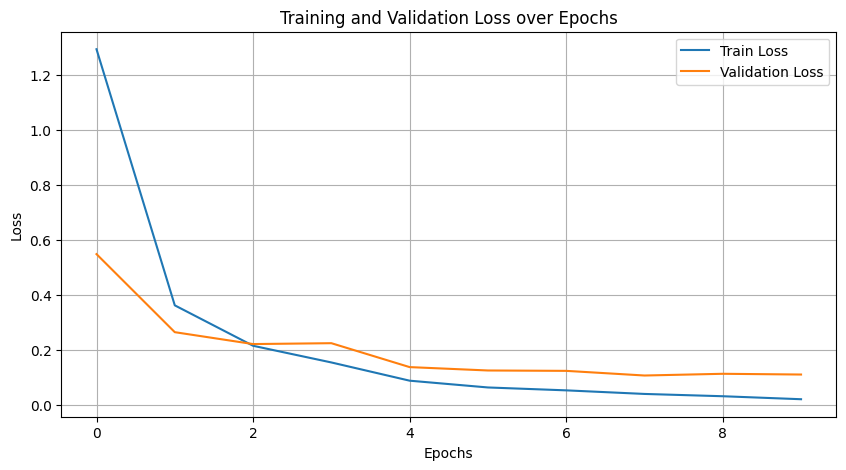

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [25]:

import tensorflow as tf
from tqdm import tqdm

modelEval = Net(num_classes=10)
dummy_input = tf.random.normal((1, 129, 71, 1))
_ = modelEval(dummy_input)
modelEval.load_weights("Net_best.weights.h5")
modelEval.compile()

modelEval.trainable = False

avg_train_performance = 0.0
for images, targets in tqdm(train_dataset):
    targets = tf.cast(targets, tf.int64)
    logits, arg_max_pred = modelEval(images, training=False)
    avg_train_performance += tf.equal(targets, arg_max_pred).numpy().sum().item() / len(targets)

avg_train_performance = avg_train_performance / len(train_dataset)

avg_val_performance = 0.0
for images, targets in tqdm(val_dataset):
    targets = tf.cast(targets, tf.int64)
    logits, arg_max_pred = modelEval(images, training=False)
    avg_val_performance += tf.equal(targets, arg_max_pred).numpy().sum().item() / len(targets)

avg_val_performance = avg_val_performance / len(val_dataset)


test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(batch_size)

avg_test_performance = 0.0
for images, targets in tqdm(test_dataset):
    targets = tf.cast(targets, tf.int64)
    logits, arg_max_pred = modelEval(images, training=False)
    avg_test_performance += tf.equal(targets, arg_max_pred).numpy().sum().item() / len(targets)

avg_test_performance = avg_test_performance / len(test_dataset)

print(f"Train Accuracy: {avg_train_performance:.4f}")
print(f"Validation Accuracy: {avg_val_performance:.4f}")
print(f"Test Accuracy: {avg_test_performance:.4f}")

100%|██████████| 390/390 [03:22<00:00,  1.92it/s]


Train Accuracy: 0.9912


100%|██████████| 84/84 [00:42<00:00,  1.97it/s]

Train Accuracy: 0.9912
Validation Accuracy: 0.9666
Test Accuracy: 0.9652


I0000 00:00:1759062111.986090  160881 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 12555 MB memory:  -> device: 0, name: AMD Radeon RX 9070 XT, pci bus id: 0000:03:00.0
2025-09-28 14:21:52.836714: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 913738476 exceeds 10% of free system memory.
  0%|          | 1/250 [01:02<4:20:16, 62.72s/it]

Iteration 1/50, Loss = 2.3074


  1%|          | 2/250 [01:05<1:52:55, 27.32s/it]

Iteration 2/50, Loss = 2.3069


  1%|          | 3/250 [01:07<1:05:30, 15.91s/it]

Iteration 3/50, Loss = 2.3050


  2%|▏         | 4/250 [01:10<43:23, 10.58s/it]  

Iteration 4/50, Loss = 2.3059


  2%|▏         | 5/250 [01:12<31:22,  7.69s/it]

Iteration 5/50, Loss = 2.2952


  2%|▏         | 6/250 [01:15<24:08,  5.93s/it]

Iteration 6/50, Loss = 2.3018


  3%|▎         | 7/250 [01:17<19:33,  4.83s/it]

Iteration 7/50, Loss = 2.2959


  3%|▎         | 8/250 [01:22<19:08,  4.75s/it]

Iteration 8/50, Loss = 2.2955


  4%|▎         | 9/250 [01:24<16:22,  4.08s/it]

Iteration 9/50, Loss = 2.2734


  4%|▍         | 10/250 [01:27<14:28,  3.62s/it]

Iteration 10/50, Loss = 2.2834


  4%|▍         | 11/250 [01:29<13:02,  3.27s/it]

Iteration 11/50, Loss = 2.2538


  5%|▍         | 12/250 [01:32<12:02,  3.04s/it]

Iteration 12/50, Loss = 2.2430


  5%|▌         | 13/250 [01:34<11:20,  2.87s/it]

Iteration 13/50, Loss = 2.2386


  6%|▌         | 14/250 [01:37<10:41,  2.72s/it]

Iteration 14/50, Loss = 2.2813


  6%|▌         | 15/250 [01:39<10:12,  2.60s/it]

Iteration 15/50, Loss = 2.2348


  6%|▋         | 16/250 [01:41<09:51,  2.53s/it]

Iteration 16/50, Loss = 2.1380


  7%|▋         | 17/250 [01:44<09:46,  2.52s/it]

Iteration 17/50, Loss = 2.1856


  7%|▋         | 18/250 [01:46<09:40,  2.50s/it]

Iteration 18/50, Loss = 2.1336


  8%|▊         | 19/250 [01:49<09:35,  2.49s/it]

Iteration 19/50, Loss = 1.8701


  8%|▊         | 20/250 [01:51<09:29,  2.48s/it]

Iteration 20/50, Loss = 2.0863


  8%|▊         | 21/250 [01:55<10:44,  2.82s/it]

Iteration 21/50, Loss = 1.9234


  9%|▉         | 22/250 [01:57<10:13,  2.69s/it]

Iteration 22/50, Loss = 2.0199


  9%|▉         | 23/250 [02:00<10:01,  2.65s/it]

Iteration 23/50, Loss = 1.8958


 10%|▉         | 24/250 [02:02<09:38,  2.56s/it]

Iteration 24/50, Loss = 2.0164


 10%|█         | 25/250 [02:05<09:21,  2.50s/it]

Iteration 25/50, Loss = 1.9071


 10%|█         | 26/250 [02:07<09:09,  2.45s/it]

Iteration 26/50, Loss = 2.0664


 11%|█         | 27/250 [02:09<09:07,  2.45s/it]

Iteration 27/50, Loss = 1.8473


 11%|█         | 28/250 [02:12<09:02,  2.44s/it]

Iteration 28/50, Loss = 1.7101


 12%|█▏        | 29/250 [02:14<08:57,  2.43s/it]

Iteration 29/50, Loss = 1.8932


 12%|█▏        | 30/250 [02:17<08:56,  2.44s/it]

Iteration 30/50, Loss = 2.0676


 12%|█▏        | 31/250 [02:19<08:54,  2.44s/it]

Iteration 31/50, Loss = 1.8030


 13%|█▎        | 32/250 [02:22<08:52,  2.44s/it]

Iteration 32/50, Loss = 1.8553


 13%|█▎        | 33/250 [02:24<08:52,  2.46s/it]

Iteration 33/50, Loss = 1.7041


 14%|█▎        | 34/250 [02:26<08:48,  2.45s/it]

Iteration 34/50, Loss = 1.8708


 14%|█▍        | 35/250 [02:31<10:43,  2.99s/it]

Iteration 35/50, Loss = 1.7579


 14%|█▍        | 36/250 [02:33<10:12,  2.86s/it]

Iteration 36/50, Loss = 1.8290


 15%|█▍        | 37/250 [02:36<09:39,  2.72s/it]

Iteration 37/50, Loss = 1.6781


 15%|█▌        | 38/250 [02:38<09:12,  2.61s/it]

Iteration 38/50, Loss = 1.4257


 16%|█▌        | 39/250 [02:40<08:52,  2.53s/it]

Iteration 39/50, Loss = 1.3428


 16%|█▌        | 40/250 [02:43<08:39,  2.47s/it]

Iteration 40/50, Loss = 1.5799


 16%|█▋        | 41/250 [02:45<08:28,  2.43s/it]

Iteration 41/50, Loss = 1.4958


 17%|█▋        | 42/250 [02:47<08:19,  2.40s/it]

Iteration 42/50, Loss = 1.6466


 17%|█▋        | 43/250 [02:50<08:12,  2.38s/it]

Iteration 43/50, Loss = 1.8625


 18%|█▊        | 44/250 [02:52<08:12,  2.39s/it]

Iteration 44/50, Loss = 2.2699


 18%|█▊        | 45/250 [02:55<08:10,  2.39s/it]

Iteration 45/50, Loss = 2.4712


 18%|█▊        | 46/250 [02:57<08:15,  2.43s/it]

Iteration 46/50, Loss = 2.3673


 19%|█▉        | 47/250 [02:59<08:14,  2.44s/it]

Iteration 47/50, Loss = 2.2346


 19%|█▉        | 48/250 [03:05<11:15,  3.35s/it]

Iteration 48/50, Loss = 4.2648


 20%|█▉        | 49/250 [03:07<10:23,  3.10s/it]

Iteration 49/50, Loss = 2.4615


 20%|██        | 50/250 [03:10<12:41,  3.81s/it]

Iteration 50/50, Loss = 2.3035


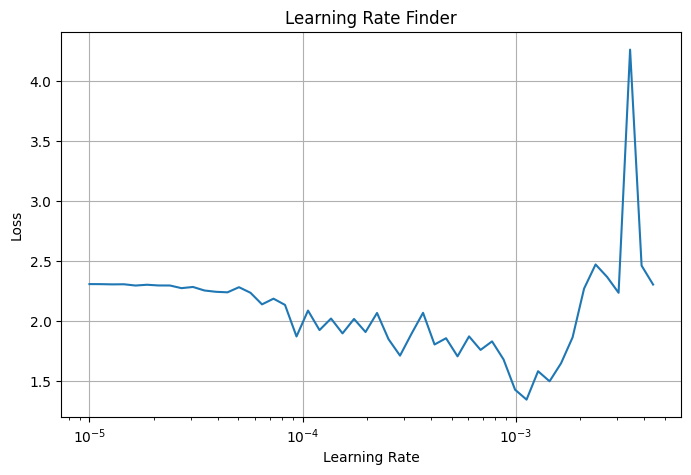

In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
batch_size = 100

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(1000).batch(batch_size)


model = Net(num_classes=10)
dummy_input = tf.zeros((1, 129, 71, 1))
_ = model(dummy_input)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-7)

lrs = []
losses = []

lr_start = 1e-5
lr_end = 0.5e-2
num_iters = 50
mult = (lr_end / lr_start) ** (1/num_iters)
lr = lr_start

iter_count = 0
for X_batch, y_batch in tqdm(train_dataset):
    if iter_count >= num_iters:
        break

    with tf.GradientTape() as tape:
        logits, preds = model(X_batch, training=True)
        loss = loss_fn(y_batch, logits)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    print(f"Iteration {iter_count+1}/{num_iters}, Loss = {loss.numpy():.4f}")

    lrs.append(lr)
    losses.append(loss.numpy())

    lr *= mult
    optimizer.learning_rate = lr

    iter_count += 1

plt.figure(figsize=(8, 5))
plt.plot(lrs, losses)
plt.xscale("log")
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Learning Rate Finder")
plt.grid(True)
plt.show()